In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split,KFold, cross_val_score,cross_validate,RandomizedSearchCV
from sklearn.metrics import mean_squared_error,r2_score,root_mean_squared_error
from sklearn.linear_model import LinearRegression,Lasso,Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from time import time

## Data Import & Exploration

In [2]:
# Switching to the source directory

project_root = os.path.abspath(os.path.join(os.getcwd(), "../"))
project_root

'C:\\Users\\91948\\Downloads\\BKs\\Projects\\personalized_health_insurance_premium_estimator'

In [3]:
# Define datasource path

data_source = 'data'
file_name = 'premiums_young'
file_extension = 'xlsx'

datasource_path = fr'{project_root}\{data_source}\{file_name}.{file_extension}'
datasource_path

'C:\\Users\\91948\\Downloads\\BKs\\Projects\\personalized_health_insurance_premium_estimator\\data\\premiums_young.xlsx'

In [4]:
# Reading the data

df = pd.read_excel(datasource_path,sheet_name='v1')

In [5]:
# Displaying the data

df.head()

,Age,Gender,Region,Marital_status,Number Of Dependants,BMI_Category,Smoking_Status,Employment_Status,Income_Level,Income_Lakhs,Medical History,Insurance_Plan,Annual_Premium_Amount
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050
2,21,Female,Southeast,Unmarried,0,Normal,Regular,Salaried,> 40L,97,No Disease,Silver,11857
3,25,Male,Southeast,Unmarried,0,Normal,No Smoking,Freelancer,10L - 25L,15,No Disease,Bronze,5684
4,20,Male,Southeast,Unmarried,2,Overweight,No Smoking,Freelancer,10L - 25L,14,No Disease,Bronze,5712


In [6]:
df.shape

(20096, 13)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20096 entries, 0 to 20095
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Age                    20096 non-null  int64 
 1   Gender                 20096 non-null  object
 2   Region                 20096 non-null  object
 3   Marital_status         20096 non-null  object
 4   Number Of Dependants   20096 non-null  int64 
 5   BMI_Category           20096 non-null  object
 6   Smoking_Status         20094 non-null  object
 7   Employment_Status      20095 non-null  object
 8   Income_Level           20092 non-null  object
 9   Income_Lakhs           20096 non-null  int64 
 10  Medical History        20096 non-null  object
 11  Insurance_Plan         20096 non-null  object
 12  Annual_Premium_Amount  20096 non-null  int64 
dtypes: int64(4), object(9)
memory usage: 2.0+ MB


## Data Cleaning

The following steps were performed during data cleaning:

- Handling missing values
- Removing duplicated rows
- Formatting numeric and categorical values
- Treating outliers to improve data quality

### Column Formatter

In [8]:
# Renaming the columns with proper formatter
# Eg: Number Of Dependants -> number_of_dependants

df.columns = df.columns.str.replace(' ','_').str.lower()

In [9]:
df.head()

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050
2,21,Female,Southeast,Unmarried,0,Normal,Regular,Salaried,> 40L,97,No Disease,Silver,11857
3,25,Male,Southeast,Unmarried,0,Normal,No Smoking,Freelancer,10L - 25L,15,No Disease,Bronze,5684
4,20,Male,Southeast,Unmarried,2,Overweight,No Smoking,Freelancer,10L - 25L,14,No Disease,Bronze,5712


### Handling Missing Values

In [10]:
# Finding the columns with NA values

df.isna().sum()

age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           2
employment_status        1
income_level             4
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
dtype: int64

In [11]:
# Dropping the Rows where it has NA value

# Before Dropping
df[df['smoking_status'].isna()].head()

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount
6853,23,Male,Southwest,Unmarried,0,Normal,NaN,Freelancer,<10L,3,No Disease,Bronze,6001
7757,19,Female,Northeast,Unmarried,0,Normal,NaN,Salaried,10L - 25L,23,No Disease,Bronze,9010


Since the count is low, the rows containing at least one missing value were dropped.

In [12]:
# Dropping
df.dropna(how='any',inplace = True)

In [13]:
# After Dropping
df[df['smoking_status'].isna()]

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount


In [14]:
df.isna().sum()

age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           0
employment_status        0
income_level             0
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
dtype: int64

In [15]:
df.reset_index(inplace=True,drop=True)

### Handling Duplicated Rows

In [16]:
# Duplicated rows

df[df.duplicated()]

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount


Although there are no duplicated rows, they are being dropped as a precautionary measure.

In [17]:
# Dropping the duplicated rows

df.drop_duplicates(inplace=True)

### Fomatting Values - Numeric Columns

In [18]:
df.dtypes

age                       int64
gender                   object
region                   object
marital_status           object
number_of_dependants      int64
bmi_category             object
smoking_status           object
employment_status        object
income_level             object
income_lakhs              int64
medical_history          object
insurance_plan           object
annual_premium_amount     int64
dtype: object

In [19]:
# Selecting only the columns with numerical values

numeric_columns = df.select_dtypes(include=['int64']).columns
numeric_columns

Index(['age', 'number_of_dependants', 'income_lakhs', 'annual_premium_amount'], dtype='object')

In [20]:
# Printing the unique values of each numeric columns to identify the values with improper formats

for col in numeric_columns:
    print(f'{col}:\n',df[col].unique())
    print('*'*100)

age:
 [18 22 21 25 20 19 23 24]
****************************************************************************************************
number_of_dependants:
 [ 0  2  1  3 -3 -1]
****************************************************************************************************
income_lakhs:
 [ 99   3  97  15  14  30   8   5  18  70  33  29   4   1  19  27  38  39
  20  36  16  92  22   9  57  24  49  52  90   2  10  21  88  11  13  25
  26  12   6  64  40  50  35  86  34  41  98  23   7  44  37  17  31  80
  81  32  46  85  58  42  28  61  78  75  51  65  43  84  71  73  66  53
  59  48  95  47  69  54  62  89  72  93  68  63  45  56  91  82  96  74
  79  67  77  60  76 100  87  55  83  94 440 580 700 790]
****************************************************************************************************
annual_premium_amount:
 [13365 11050 11857 ...  6585  9783 14498]
****************************************************************************************************


The negative values in `number_of_dependents` should be handled by converting them to their absolute values.

In [21]:
# Before formatting

df['number_of_dependants'].unique()

array([ 0,  2,  1,  3, -3, -1])

In [22]:
df['number_of_dependants'] = abs(df['number_of_dependants'])

In [23]:
# After formatting

df['number_of_dependants'].unique()

array([0, 2, 1, 3])

### Fomatting Values - Categorical Columns

In [24]:
# Selecting only the columns with categorical values

cat_columns = df.select_dtypes(include=['object']).columns
cat_columns

Index(['gender', 'region', 'marital_status', 'bmi_category', 'smoking_status',
       'employment_status', 'income_level', 'medical_history',
       'insurance_plan'],
      dtype='object')

In [25]:
# Printing the unique values of each categorical columns to identify the values with improper formats

for col in cat_columns:
    print(f'{col}:\n',list(df[col].unique()))
    print('*'*100)

gender:
 ['Male', 'Female']
****************************************************************************************************
region:
 ['Northeast', 'Northwest', 'Southeast', 'Southwest']
****************************************************************************************************
marital_status:
 ['Unmarried', 'Married']
****************************************************************************************************
bmi_category:
 ['Overweight', 'Underweight', 'Normal', 'Obesity']
****************************************************************************************************
smoking_status:
 ['Regular', 'No Smoking', 'Occasional', 'Smoking=0', 'Does Not Smoke', 'Not Smoking']
****************************************************************************************************
employment_status:
 ['Self-Employed', 'Freelancer', 'Salaried']
****************************************************************************************************
income_level:
 ['> 40L', '<10

As indicated by the above result, the `smoking_status` column contains multiple values with the same meaning; therefore, this column will be formatted.

In [26]:
# Before formatting

df['smoking_status'].unique()

array(['Regular', 'No Smoking', 'Occasional', 'Smoking=0',
       'Does Not Smoke', 'Not Smoking'], dtype=object)

In [27]:
# Replacing values with desired formats

df['smoking_status'] = df['smoking_status'].replace(
    {
       'Smoking=0' : 'No Smoking',
        'Does Not Smoke' : 'No Smoking',
        'Not Smoking' : 'No Smoking',
    }
)

In [28]:
# After formatting

df['smoking_status'].unique()

array(['Regular', 'No Smoking', 'Occasional'], dtype=object)

### Outlier Treatment

In [29]:
df.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,20090.000000,20090.000000,20090.000000,20090.000000
mean,21.494375,0.722598,22.510851,8142.096267
std,2.294052,0.937200,23.420493,2749.906347
min,18.000000,0.000000,1.000000,3501.000000
25%,19.000000,0.000000,6.000000,6022.250000
50%,22.000000,0.000000,16.000000,7939.000000
75%,23.000000,1.000000,31.000000,9561.000000
max,25.000000,3.000000,790.000000,18186.000000


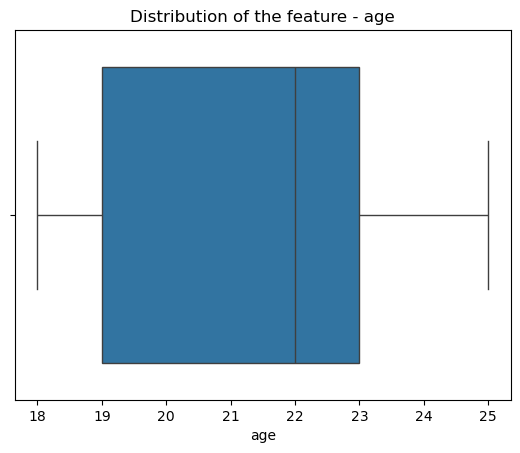

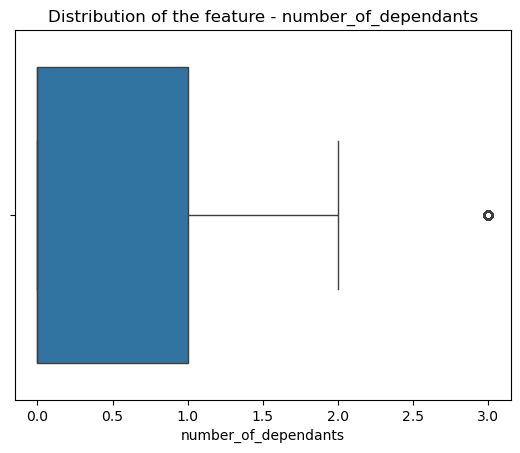

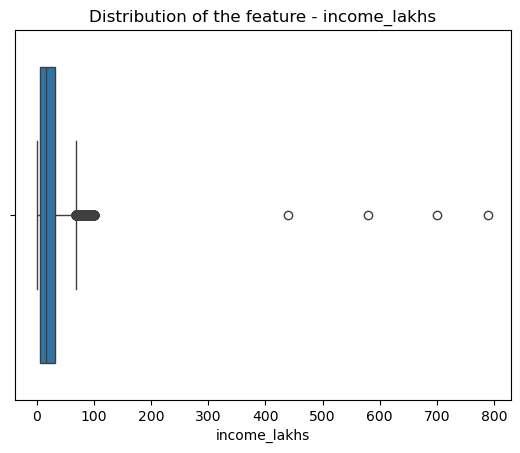

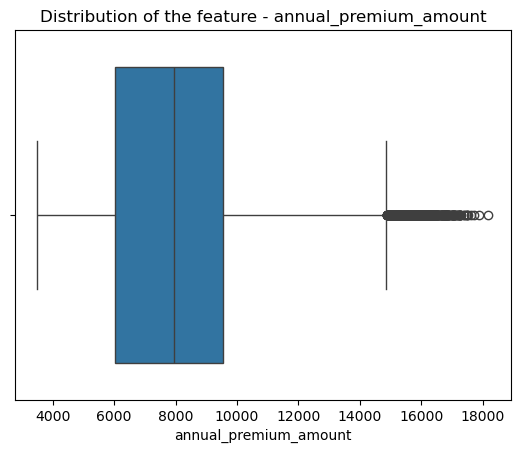

In [30]:
# Plotting box plot for each numerical columns to detect outliers

for col in numeric_columns:
    sns.boxplot(data=df,x=col)
    plt.title(f'Distribution of the feature - {col}')
    plt.show()

As seen above, outliers are present in the `income_lakhs` column. This is also demonstrated by the box plot shown above.

#### Age

In [31]:
# Before
df['age'].unique()

array([18, 22, 21, 25, 20, 19, 23, 24])

In [32]:
# Selecting only the rows where age <= 100. Because age > 100 is outlier

df1 = df[df['age'] <= 100]
df1.reset_index(inplace=True,drop=True)

In [33]:
# After
df1['age'].unique()

array([18, 22, 21, 25, 20, 19, 23, 24])

#### Income

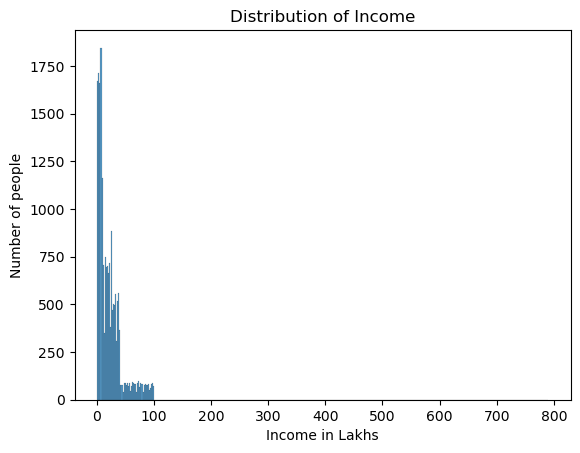

In [34]:
# Distribution of Income using Histogram

sns.histplot(data=df1,x='income_lakhs')
plt.title('Distribution of Income')
plt.xlabel('Income in Lakhs')
plt.ylabel('Number of people')
plt.show()

In [35]:
# Determining Lower Salary Boundary and Upper Salary Boundary using IQR Method

# Quartile 1 and Quartile 3

q1 = np.percentile(df1['income_lakhs'],25)
q3 = np.percentile(df1['income_lakhs'],75)
print(f'Q1 -> {q1}\nQ3 -> {q3}')

# Inter Qurartile Range

iqr = q3-q1
print('IQR ->',iqr)

# Lower and Upper boundary using IQR

lower_boundary = q1 - (iqr * 1.5)
upper_boundary = q3 + (iqr * 1.5)
print(f'Lower Boundary -> {lower_boundary}\nUpper Boundary -> {upper_boundary}')

Q1 -> 6.0
Q3 -> 31.0
IQR -> 25.0
Lower Boundary -> -31.5
Upper Boundary -> 68.5


NOTE:

The current upper boundary is too low. Therefore, consultation with the business team will be conducted to determine the optimal upper boundary for identifying outliers in the income_lakhs column.

It has been decided that the upper boundary will be set at 1 crore (i.e., 100 lakhs). Any values exceeding this threshold will be considered outliers.

In [36]:
# Selecting only the rows where income <= 100 lakhs. Because income > 100 lakhs is outlier

income_threshold = 100
df2 = df1[df1['income_lakhs'] <= income_threshold]

In [37]:
df2.reset_index(drop=True,inplace=True)

In [38]:
df2

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050
2,21,Female,Southeast,Unmarried,0,Normal,Regular,Salaried,> 40L,97,No Disease,Silver,11857
3,25,Male,Southeast,Unmarried,0,Normal,No Smoking,Freelancer,10L - 25L,15,No Disease,Bronze,5684
4,20,Male,Southeast,Unmarried,2,Overweight,No Smoking,Freelancer,10L - 25L,14,No Disease,Bronze,5712
...,...,...,...,...,...,...,...,...,...,...,...,...,...
20081,18,Female,Southeast,Unmarried,0,Underweight,No Smoking,Freelancer,> 40L,91,No Disease,Gold,11603
20082,23,Female,Northwest,Unmarried,0,Obesity,Occasional,Freelancer,> 40L,57,Diabetes,Gold,14498
20083,24,Female,Northwest,Unmarried,0,Underweight,No Smoking,Self-Employed,25L - 40L,35,No Disease,Bronze,9111
20084,21,Male,Northwest,Unmarried,0,Normal,Regular,Freelancer,25L - 40L,32,No Disease,Bronze,8564


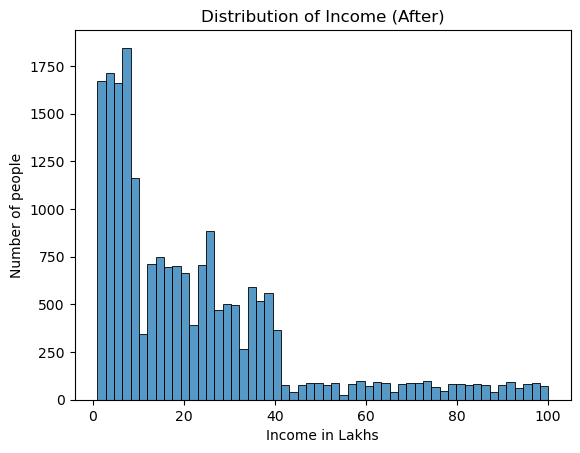

In [39]:
# After Treating outliers in 'income_lakhs' columns

sns.histplot(data=df2,x='income_lakhs')
plt.title('Distribution of Income (After)')
plt.xlabel('Income in Lakhs')
plt.ylabel('Number of people')
plt.show()

## EDA

Exploratory Data Analysis (EDA) is performed as follows:

- Univariate analysis on numeric columns
- Univariate analysis on categorical columns
- Bivariate analysis on numeric columns
- Bivariate analysis on categorical columns

### Univariate Analysis - Numeric Columns

The distribution of numerical columns will be plotted using histograms.

In [40]:
numeric_columns

Index(['age', 'number_of_dependants', 'income_lakhs', 'annual_premium_amount'], dtype='object')

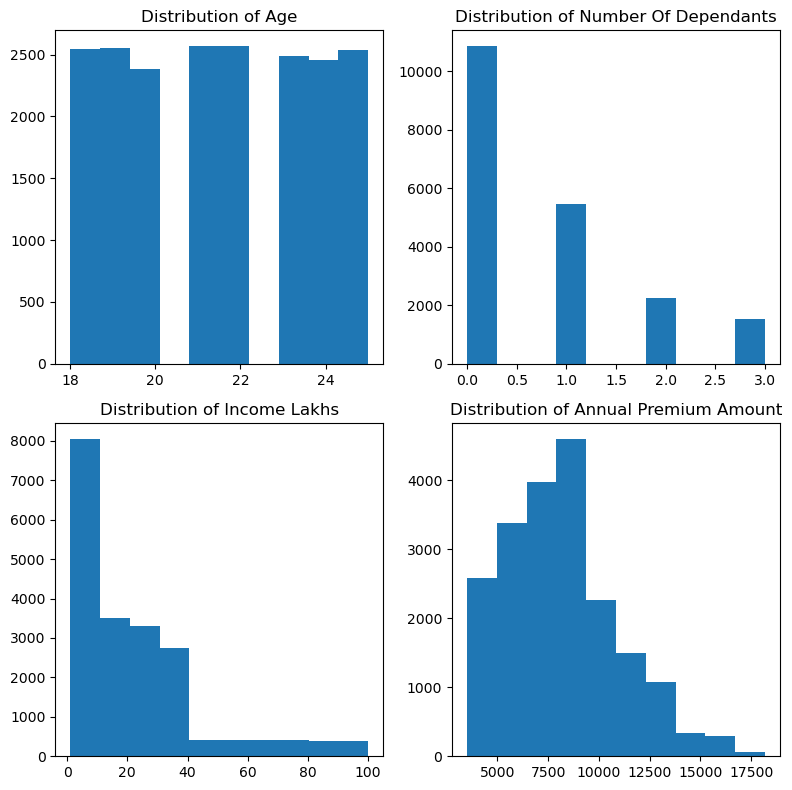

In [41]:
# Plotting Distribution for all numerical columns

fig , ax = plt.subplots(2,2,figsize=(8,8))

# Iterator initiation to retrive one value at a time
it = iter(numeric_columns)

for i in range(2):
    for j in range(2):
        # To retrive one value at a time
        col = next(it)
        # Format column name for display: capitalize first letter of each word and replace underscores with spaces
        x_ax = col.title().replace('_',' ')
        ax[i,j].hist(x=df2[col])
        ax[i,j].set_title(f'Distribution of {x_ax}')
        
# To adjust subplot parameters to give specified padding and prevent overlap of labels
plt.tight_layout()
plt.show()

### Univariate Analysis - Categorical Columns

The distribution of categorical columns will be plotted using barcharts.

In [42]:
df2[cat_columns]

,gender,region,marital_status,bmi_category,smoking_status,employment_status,income_level,medical_history,insurance_plan
0,Male,Northeast,Unmarried,Overweight,Regular,Self-Employed,> 40L,High blood pressure,Silver
1,Female,Northwest,Unmarried,Underweight,No Smoking,Freelancer,<10L,No Disease,Silver
2,Female,Southeast,Unmarried,Normal,Regular,Salaried,> 40L,No Disease,Silver
3,Male,Southeast,Unmarried,Normal,No Smoking,Freelancer,10L - 25L,No Disease,Bronze
4,Male,Southeast,Unmarried,Overweight,No Smoking,Freelancer,10L - 25L,No Disease,Bronze
...,...,...,...,...,...,...,...,...,...
20081,Female,Southeast,Unmarried,Underweight,No Smoking,Freelancer,> 40L,No Disease,Gold
20082,Female,Northwest,Unmarried,Obesity,Occasional,Freelancer,> 40L,Diabetes,Gold
20083,Female,Northwest,Unmarried,Underweight,No Smoking,Self-Employed,25L - 40L,No Disease,Bronze
20084,Male,Northwest,Unmarried,Normal,Regular,Freelancer,25L - 40L,No Disease,Bronze


In previous runs, the x-axis labels for the `medical_history` column were misaligned in the plots. To resolve this issue, the values will be mapped using the dictionary *ds_dict* as shown below.

In [43]:
ds_dict = {'No Disease': 'NO DISEASE',
 'Diabetes': 'DB',
 'High blood pressure': 'HBP',
 'Thyroid': 'THY',
 'Heart disease': 'HD',
 'Diabetes & High blood pressure': 'DB & HBP',
 'High blood pressure & Heart disease': 'HBP & HD',
 'Diabetes & Thyroid': 'DB & THY',
 'Diabetes & Heart disease': 'DB & HD'}

ds_dict

{'No Disease': 'NO DISEASE',
 'Diabetes': 'DB',
 'High blood pressure': 'HBP',
 'Thyroid': 'THY',
 'Heart disease': 'HD',
 'Diabetes & High blood pressure': 'DB & HBP',
 'High blood pressure & Heart disease': 'HBP & HD',
 'Diabetes & Thyroid': 'DB & THY',
 'Diabetes & Heart disease': 'DB & HD'}

In [44]:
# Showing how mapping works

print('Without Mapping:')
print(list(df2['medical_history'].value_counts(normalize=True).index))
print('\n','*'*100,'\n')
print('With Mapping:')
print(list(df2['medical_history'].value_counts(normalize=True).index.map(ds_dict)))

Without Mapping:
['No Disease', 'Diabetes', 'High blood pressure', 'Thyroid', 'Diabetes & High blood pressure', 'High blood pressure & Heart disease', 'Diabetes & Thyroid', 'Heart disease', 'Diabetes & Heart disease']

 **************************************************************************************************** 

With Mapping:
['NO DISEASE', 'DB', 'HBP', 'THY', 'DB & HBP', 'HBP & HD', 'DB & THY', 'HD', 'DB & HD']


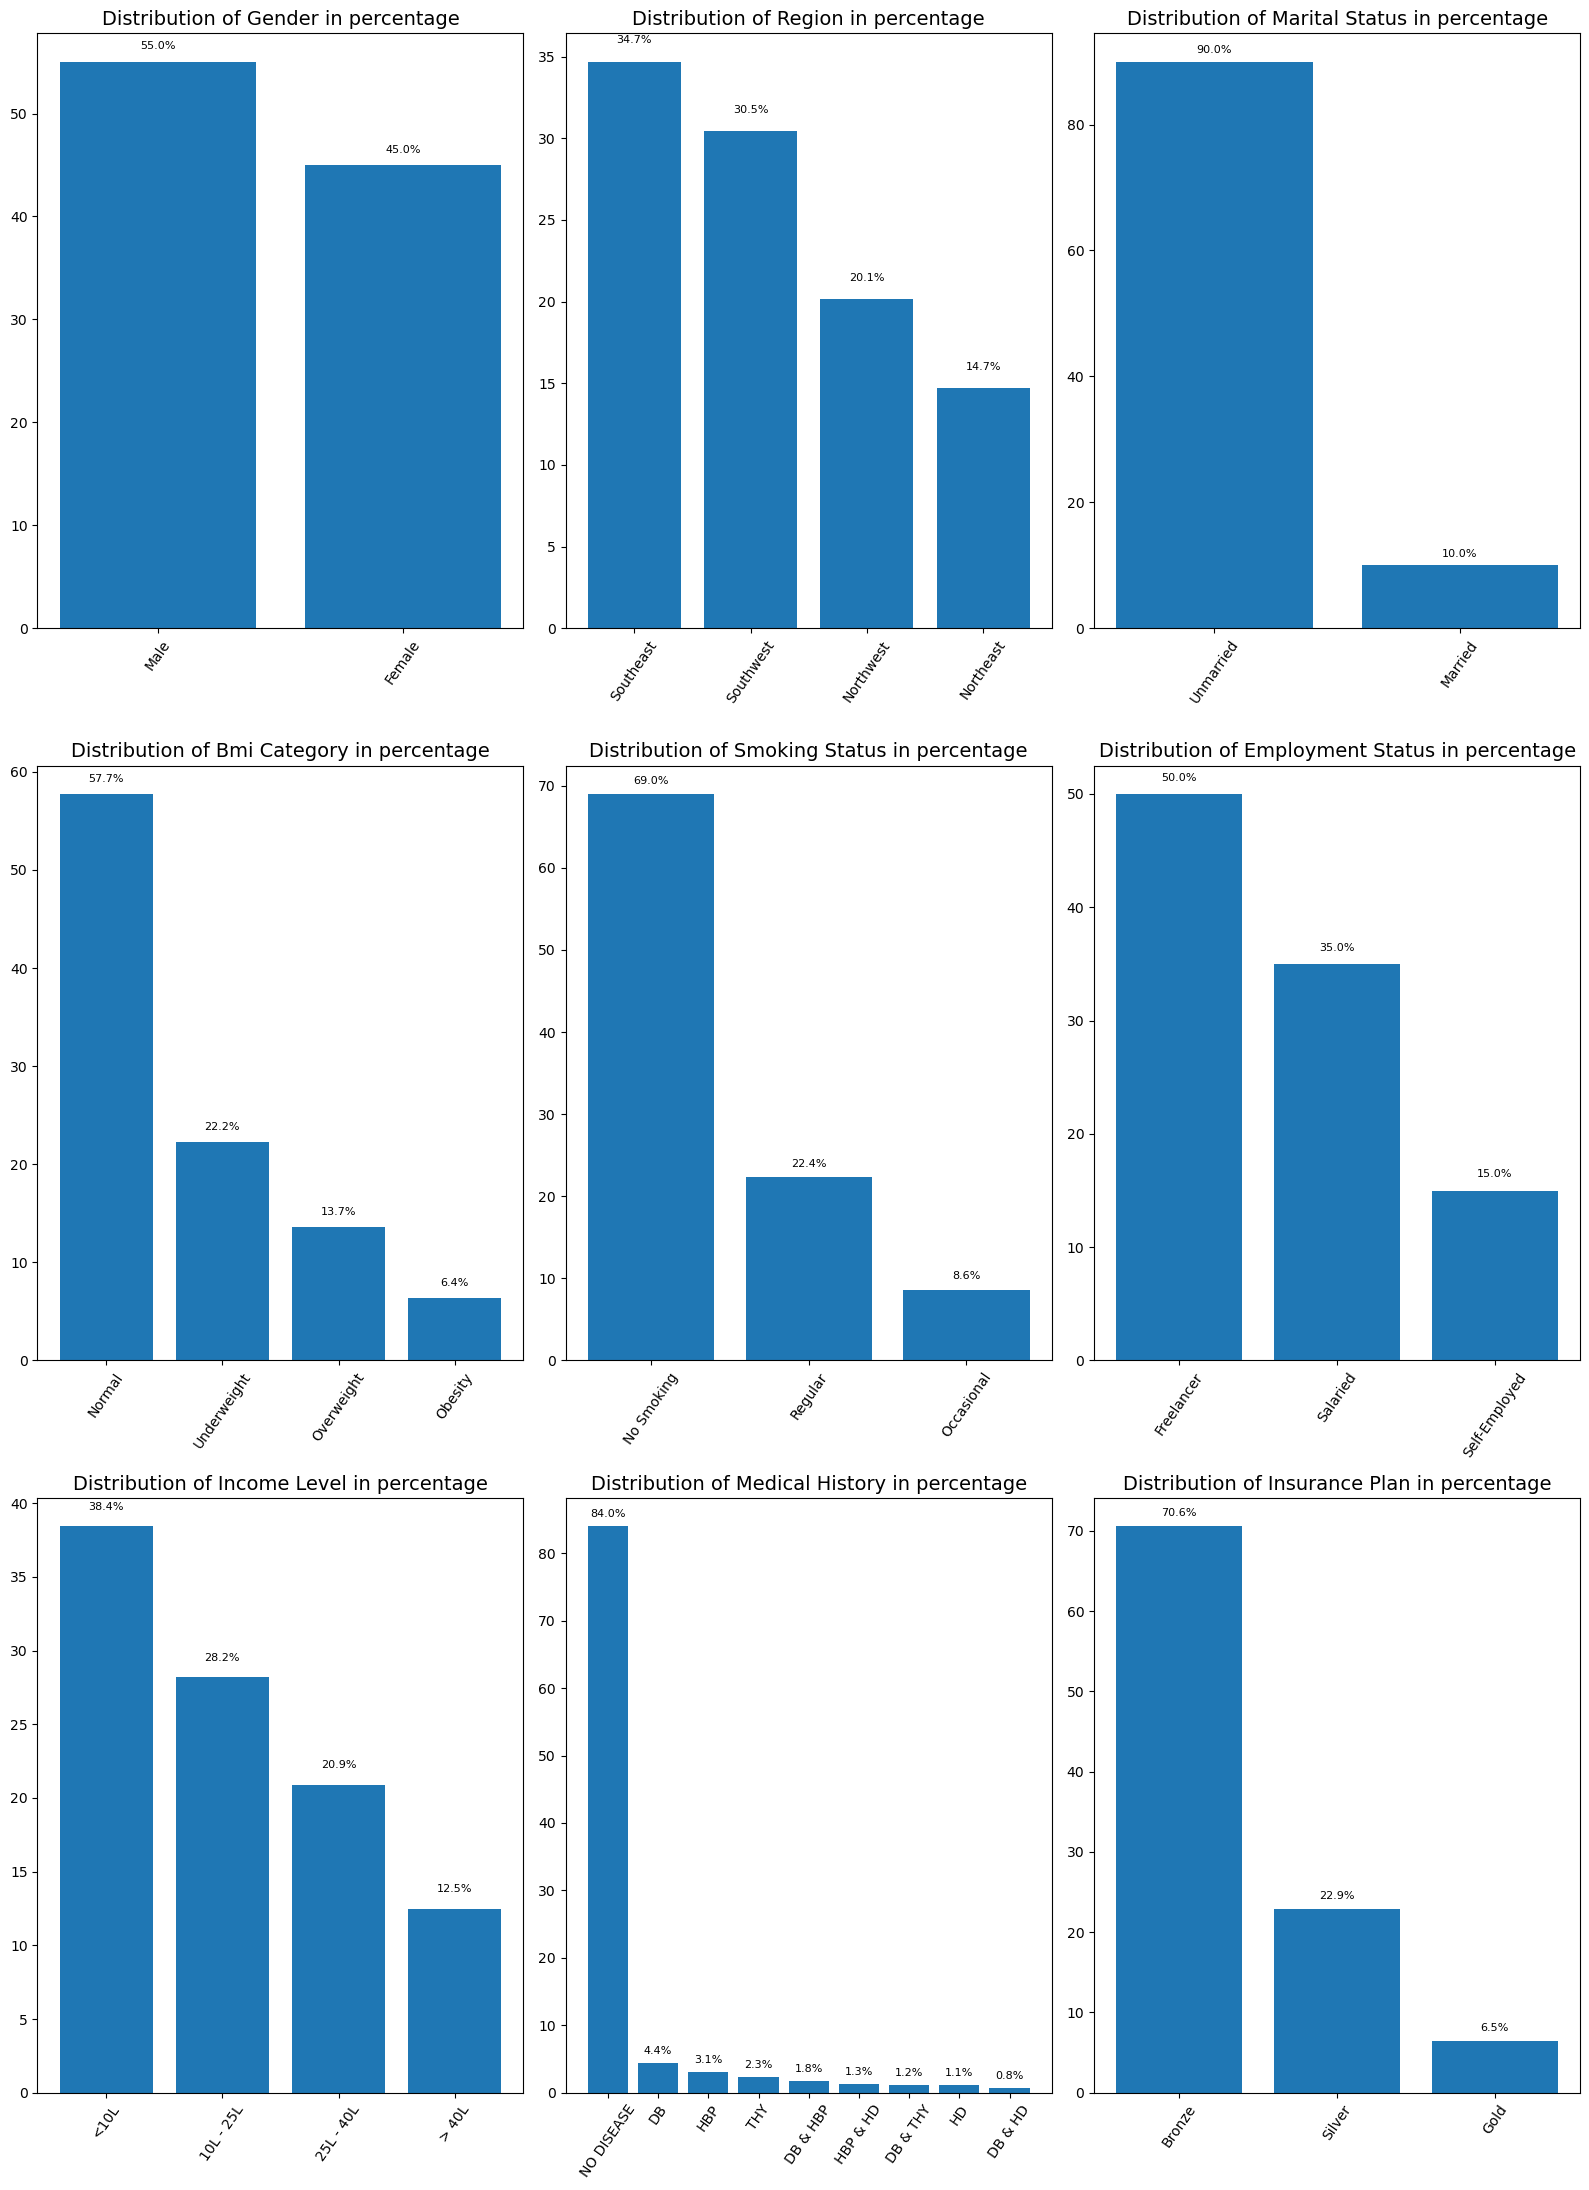

In [45]:
# Plotting Distribution for all categorical columns

fig, ax = plt.subplots(3,3,figsize=(16,22))

# Iterator initiation to retrive one value at a time
it = iter(cat_columns)

for i in range(3):
    for j in range(3):
        # To retrive one value at a time
        col = next(it)
        
        # Format column name for display: capitalize first letter of each word and replace underscores with spaces
        x_ax = col.title().replace('_',' ')

        # Map the 'medical_history' column using ds_dict to ensure consistent and clean labels for plotting
        
        if col == 'medical_history':
            x_val = df2[col].value_counts(normalize=True).index.map(ds_dict)
        else:
            x_val = df2[col].value_counts(normalize=True).index
            
        h_val = df2[col].value_counts(normalize=True).values * 100
        ax[i,j].bar(x=x_val,height=h_val)
        ax[i,j].set_title(f'Distribution of {x_ax} in percentage',fontsize=14)
        ax[i,j].tick_params(axis='x', rotation=55)
        
        # Annotate each bar with its corresponding percentage value for better interpretability
        for idx, val in enumerate(h_val):
            ax[i,j].text(idx, val + 1, f'{round(val,1)}%', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

### Bivariate Analysis - Numeric Columns

The relationship between each numerical column (excluding the `annual_premium_amount` column itself) and the `annual_premium_amount` column will be plotted to analyze potential correlations.

In [46]:
df2[numeric_columns]

,age,number_of_dependants,income_lakhs,annual_premium_amount
0,18,0,99,13365
1,22,0,3,11050
2,21,0,97,11857
3,25,0,15,5684
4,20,2,14,5712
...,...,...,...,...
20081,18,0,91,11603
20082,23,0,57,14498
20083,24,0,35,9111
20084,21,0,32,8564


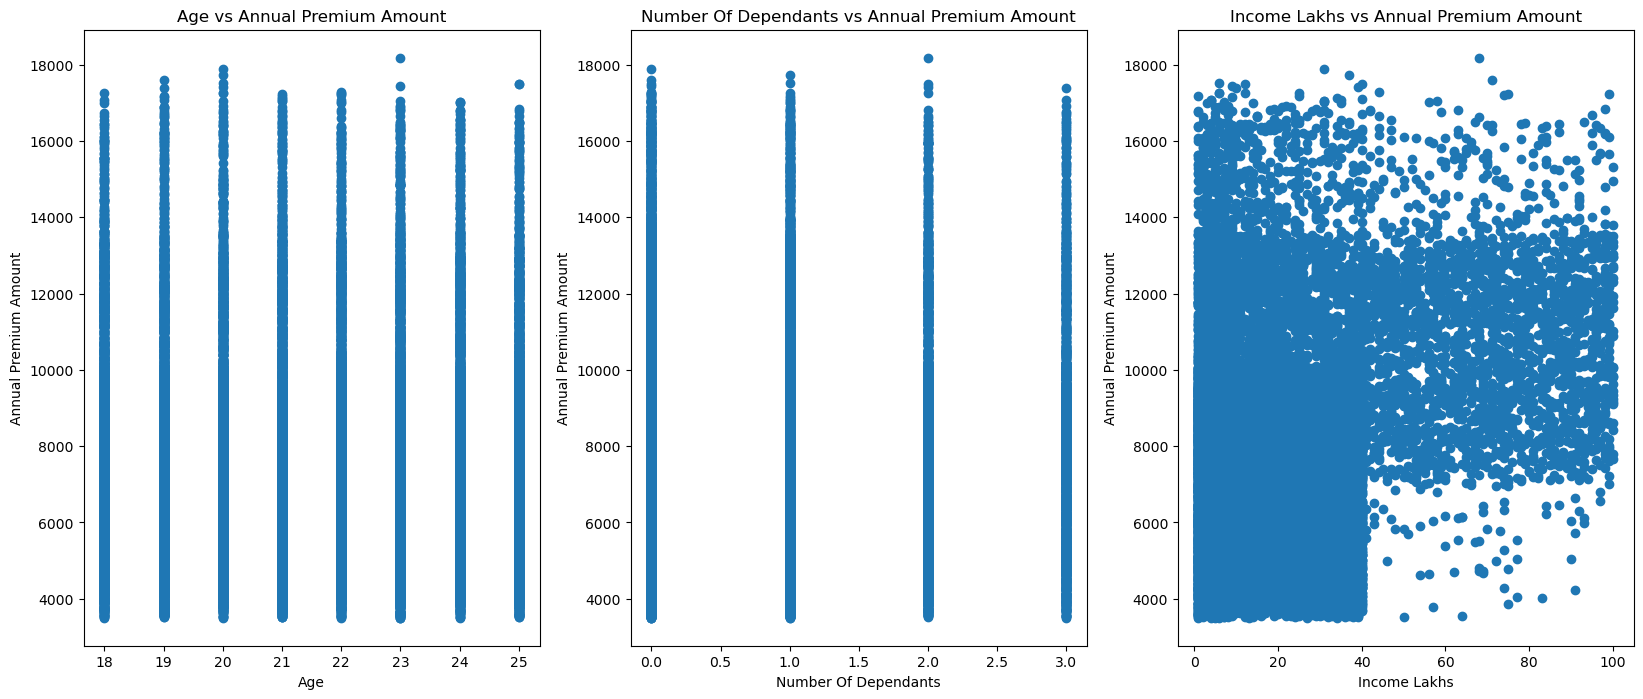

In [47]:
# Plotting the scatter plots

fig, ax = plt.subplots(1,3,figsize=(20,8))

for i in range(3):
    col = numeric_columns[i]
    
    # Format column names for display: capitalize first letter of each word and replace underscores with spaces
    x_ax = col.title().replace('_',' ')
    y_ax = 'annual_premium_amount'.title().replace('_',' ')
    
    ax[i].scatter(x=df2[col],y=df2['annual_premium_amount'])
    ax[i].set_title(f'{x_ax} vs {y_ax}')
    ax[i].set_xlabel(x_ax)
    ax[i].set_ylabel(y_ax)

### Bivariate Analysis - Categorical

The relationship between the categorical columns `income_level` and `insurance_plan` will be explored using multiple approaches:

* Cross-tabulation
* Grouped Bar Chart
* Stacked Bar Chart
* Heatmap
  

In [48]:
df2.head()

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050
2,21,Female,Southeast,Unmarried,0,Normal,Regular,Salaried,> 40L,97,No Disease,Silver,11857
3,25,Male,Southeast,Unmarried,0,Normal,No Smoking,Freelancer,10L - 25L,15,No Disease,Bronze,5684
4,20,Male,Southeast,Unmarried,2,Overweight,No Smoking,Freelancer,10L - 25L,14,No Disease,Bronze,5712


#### Cross-tabulation

The frequency distribution between `income_level` and `insurance_plan` will be examined using a cross-tabulation, which will display the number of individuals in each combination of income level and insurance plan.

In [49]:
ct = pd.crosstab(df['income_level'],df['insurance_plan'])
ct

insurance_plan,Bronze,Gold,Silver
income_level,,,
10L - 25L,4508,326,828
25L - 40L,3382,209,608
<10L,6172,404,1145
> 40L,116,366,2026


In [143]:
# Reorder rows and columns
row_order = ['<10L', '10L - 25L', '25L - 40L', '> 40L']
col_order = ['Bronze', 'Silver', 'Gold']

In [144]:
# Reordered CT

ct = ct.loc[row_order, col_order]
ct

insurance_plan,Bronze,Silver,Gold
income_level,,,
<10L,6172,1145,404
10L - 25L,4508,828,326
25L - 40L,3382,608,209
> 40L,116,2026,366


#### Grouped Bar Chart

The count of each `insurance_plan` across different `income_level` categories will be visualized using grouped bar charts, where each income level will have side-by-side bars representing the different insurance plans for easy comparison.

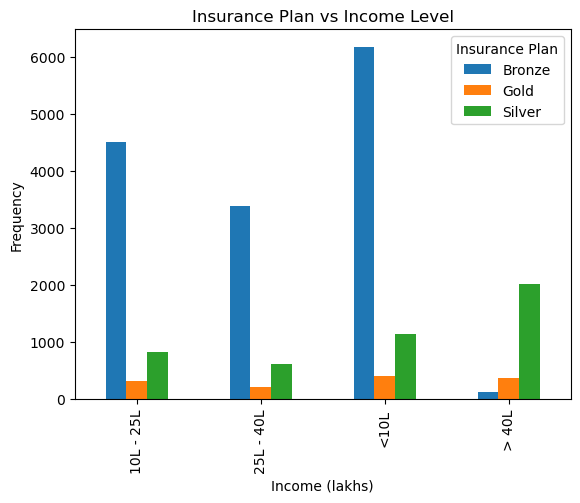

In [50]:
ct.plot(kind='bar')
plt.title('Insurance Plan vs Income Level')
plt.xlabel('Income (lakhs)')
plt.ylabel('Frequency')
plt.legend(title='Insurance Plan')
plt.show()

#### Stacked Bar Chart

The distribution of `insurance_plan` within each `income_level` will be represented in a stacked bar chart format, helping to understand the proportion of each plan type within the income categories.

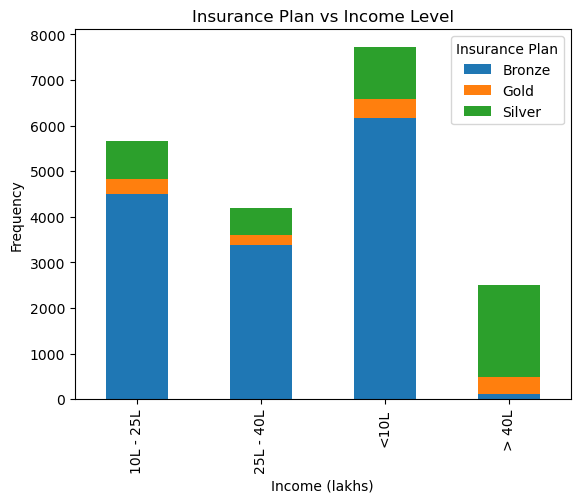

In [51]:
ct.plot(kind='bar',stacked=True)
plt.title('Insurance Plan vs Income Level')
plt.xlabel('Income (lakhs)')
plt.ylabel('Frequency')
plt.legend(title='Insurance Plan')
plt.show()

#### Heatmap

The intensity of the relationship between `insurance_plan` and `income_level` will be visualized using a heatmap, where the cells are color-coded based on frequency to highlight patterns and concentrations in the data.

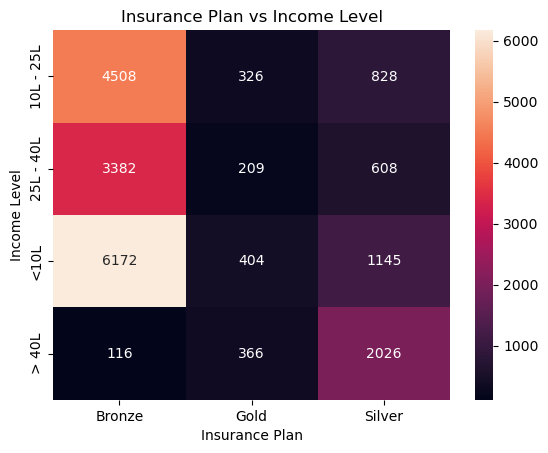

In [52]:
sns.heatmap(ct,annot=True,fmt='0')
plt.title('Insurance Plan vs Income Level')
plt.xlabel('Insurance Plan')
plt.ylabel('Income Level')
plt.show()

## Feature Engineering

The following feature engineering steps were performed:

- Created new features as required
- Transformed features, including encoding categorical variables
- Selected important features using statistical methods such as Variance Inflation Factor (VIF) and correlation analysis

### Feature Creation - 'total_risk_score'

In this we created a new feature `total_risk_score` from `medical_history` column

In [53]:
# Extract all distinct medical conditions listed in the dataset

df2['medical_history'].unique()

array(['High blood pressure', 'No Disease',
       'Diabetes & High blood pressure', 'Diabetes & Heart disease',
       'Diabetes', 'Diabetes & Thyroid', 'Heart disease', 'Thyroid',
       'High blood pressure & Heart disease'], dtype=object)

The following risk scores, as provided by the business, will be assigned to the corresponding medical conditions:

* Heart disease: 8
* Diabetes: 6
* High blood pressure: 6
* Thyroid: 5
* No Disease: 0
* None: 0

In [54]:
df3 = df2.copy()
df3.head()

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050
2,21,Female,Southeast,Unmarried,0,Normal,Regular,Salaried,> 40L,97,No Disease,Silver,11857
3,25,Male,Southeast,Unmarried,0,Normal,No Smoking,Freelancer,10L - 25L,15,No Disease,Bronze,5684
4,20,Male,Southeast,Unmarried,2,Overweight,No Smoking,Freelancer,10L - 25L,14,No Disease,Bronze,5712


In [55]:
# Split the 'medical_history' column into 'disease1' and 'disease2' using '&' as the delimiter

df3[['disease1','disease2']] = df3['medical_history'].str.lower().str.split(' & ',expand=True)
df3.head()

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365,high blood pressure,None
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050,no disease,None
2,21,Female,Southeast,Unmarried,0,Normal,Regular,Salaried,> 40L,97,No Disease,Silver,11857,no disease,None
3,25,Male,Southeast,Unmarried,0,Normal,No Smoking,Freelancer,10L - 25L,15,No Disease,Bronze,5684,no disease,None
4,20,Male,Southeast,Unmarried,2,Overweight,No Smoking,Freelancer,10L - 25L,14,No Disease,Bronze,5712,no disease,None


In [56]:
# Risk Score Dictionary

risk_score_dict = {
    'heart disease' : 8,
'diabetes' : 6,
'high blood pressure' : 6,
'thyroid' : 5,
'no disease' : 0,
None : 0
}

In [57]:
# Mapping each disease to its corresponding score using a predefined dictionary

df3['disease1_score'] = df3['disease1'].map(risk_score_dict)
df3['disease2_score'] = df3['disease2'].map(risk_score_dict)
df3.sample(2)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,disease1_score,disease2_score
11407,25,Female,Northeast,Unmarried,1,Underweight,Occasional,Freelancer,<10L,9,No Disease,Bronze,8200,no disease,None,0,0
11066,22,Female,Southeast,Married,3,Underweight,No Smoking,Freelancer,25L - 40L,38,No Disease,Bronze,7953,no disease,None,0,0


In [58]:
# Check if all diseases have been assigned a score and identify any missing values

print('Unique Scores in Disease1 -> ',df3['disease1_score'].unique())
print('Unique Scores in Disease2 -> ',df3['disease2_score'].unique())

Unique Scores in Disease1 ->  [6 0 8 5]
Unique Scores in Disease2 ->  [0 6 8 5]


Since there are no NaN values, it can be concluded that all entries in the `disease1` and `disease2` columns have been successfully mapped.

In [59]:
# Calculating the total risk score by summing 'disease1_score' and 'disease2_score'

df3['total_risk_score'] = df3['disease1_score'] + df3['disease2_score']
df3.sample(4)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,disease1_score,disease2_score,total_risk_score
8247,18,Female,Southeast,Unmarried,1,Normal,Regular,Freelancer,25L - 40L,35,No Disease,Bronze,8254,no disease,None,0,0,0
382,22,Female,Southwest,Unmarried,2,Normal,No Smoking,Salaried,<10L,4,No Disease,Bronze,6777,no disease,None,0,0,0
16064,21,Female,Northeast,Unmarried,1,Obesity,No Smoking,Freelancer,10L - 25L,25,No Disease,Bronze,6782,no disease,None,0,0,0
12020,20,Male,Northwest,Unmarried,1,Normal,Regular,Salaried,25L - 40L,35,No Disease,Bronze,5146,no disease,None,0,0,0


The following columns are being dropped as they are no longer needed: `medical_history`, `disease1`, `disease2`, `disease1_score`, and `disease2_score`.

In [60]:
cols_to_drop = ['medical_history', 'disease1', 'disease2', 'disease1_score', 'disease2_score']
df4 = df3.drop(cols_to_drop,axis=1)
df4.reset_index(drop=True,inplace=True)
df4

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,insurance_plan,annual_premium_amount,total_risk_score
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,Silver,13365,6
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,Silver,11050,0
2,21,Female,Southeast,Unmarried,0,Normal,Regular,Salaried,> 40L,97,Silver,11857,0
3,25,Male,Southeast,Unmarried,0,Normal,No Smoking,Freelancer,10L - 25L,15,Bronze,5684,0
4,20,Male,Southeast,Unmarried,2,Overweight,No Smoking,Freelancer,10L - 25L,14,Bronze,5712,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
20081,18,Female,Southeast,Unmarried,0,Underweight,No Smoking,Freelancer,> 40L,91,Gold,11603,0
20082,23,Female,Northwest,Unmarried,0,Obesity,Occasional,Freelancer,> 40L,57,Gold,14498,6
20083,24,Female,Northwest,Unmarried,0,Underweight,No Smoking,Self-Employed,25L - 40L,35,Bronze,9111,0
20084,21,Male,Northwest,Unmarried,0,Normal,Regular,Freelancer,25L - 40L,32,Bronze,8564,0


### Feature Cleaning & Transformation

The following transformations were applied to the dataset features:

- Label Encoding for ordinal categorical variables (to preserve order)
- One Hot Encodingfor nominal categorical variables (to avoid introducing ordinal relationships)

In [61]:
df5 = df4.copy()
df5.head()

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,insurance_plan,annual_premium_amount,total_risk_score
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,Silver,13365,6
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,Silver,11050,0
2,21,Female,Southeast,Unmarried,0,Normal,Regular,Salaried,> 40L,97,Silver,11857,0
3,25,Male,Southeast,Unmarried,0,Normal,No Smoking,Freelancer,10L - 25L,15,Bronze,5684,0
4,20,Male,Southeast,Unmarried,2,Overweight,No Smoking,Freelancer,10L - 25L,14,Bronze,5712,0


#### Label Encodig - 'income_level'

In [62]:
# Extract all distinct income levels listed in the dataset

df5.income_level.unique()

array(['> 40L', '<10L', '10L - 25L', '25L - 40L'], dtype=object)

In [63]:
# Income level dictionary

income_level_dict =  {
        '<10L' : 1,
        '10L - 25L' : 2,
        '25L - 40L' : 3,
        '> 40L' : 4
    }

In [64]:
# Mapping each income level to a value using a predefined dictionary

df5['income_level'] = df5['income_level'].map(income_level_dict)

In [65]:
# After mapping

df5.income_level.unique()

array([4, 1, 2, 3])

#### Label Encodig - 'insurance_plan'

In [66]:
# Extract all distinct insurance plan listed in the dataset

df5.insurance_plan.unique()

array(['Silver', 'Bronze', 'Gold'], dtype=object)

In [67]:
# Insurance Plan dictionary

insurance_plan_dict = {
        'Bronze' : 1,
        'Silver' : 2,
        'Gold' : 3,
    }

In [68]:
# Mapping each insurance plan to a value using a predefined dictionary

df5['insurance_plan'] = df5['insurance_plan'].map(insurance_plan_dict)

In [69]:
# After mapping

df5.insurance_plan.unique()

array([2, 1, 3])

#### One Hot Encoding

In [70]:
# Selecting columns to perform one hot encoding

cols_to_encode = ['gender', 'region', 'marital_status', 'bmi_category', 'smoking_status', 'employment_status']
cols_to_encode

['gender',
 'region',
 'marital_status',
 'bmi_category',
 'smoking_status',
 'employment_status']

In [71]:
# Performing One Hot Encoding on df5

df6 = pd.get_dummies(df5,columns = cols_to_encode,dtype=int,drop_first=True)

In [72]:
df6.sample(5)

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,annual_premium_amount,total_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
14559,24,0,2,15,1,9523,0,0,0,1,0,1,0,0,1,0,0,1,0
12254,23,2,1,6,1,8694,0,1,0,0,0,1,0,0,0,1,0,1,0
14687,25,1,3,28,1,7949,0,1,0,0,1,1,0,1,0,0,1,0,0
6084,18,0,4,91,2,12988,0,1,0,0,1,1,0,0,0,0,0,0,1
17230,22,2,3,33,1,5416,0,1,0,0,1,1,0,0,0,0,1,0,1


In [73]:
df6.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20086 entries, 0 to 20085
Data columns (total 19 columns):
 #   Column                           Non-Null Count  Dtype
---  ------                           --------------  -----
 0   age                              20086 non-null  int64
 1   number_of_dependants             20086 non-null  int64
 2   income_level                     20086 non-null  int64
 3   income_lakhs                     20086 non-null  int64
 4   insurance_plan                   20086 non-null  int64
 5   annual_premium_amount            20086 non-null  int64
 6   total_risk_score                 20086 non-null  int64
 7   gender_Male                      20086 non-null  int64
 8   region_Northwest                 20086 non-null  int64
 9   region_Southeast                 20086 non-null  int64
 10  region_Southwest                 20086 non-null  int64
 11  marital_status_Unmarried         20086 non-null  int64
 12  bmi_category_Obesity             20086 non-nul

In [74]:
# Showing all the non-encoded columns and one encoded columns from each category

sampled_encoded_cols_index = [0,1,2,3,4,5,6,7,8,11,12,15,17]

df6.iloc[0:5,sampled_encoded_cols_index]

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,annual_premium_amount,total_risk_score,gender_Male,region_Northwest,marital_status_Unmarried,bmi_category_Obesity,smoking_status_Occasional,employment_status_Salaried
0,18,0,4,99,2,13365,6,1,0,1,0,0,0
1,22,0,1,3,2,11050,0,0,1,1,0,0,0
2,21,0,4,97,2,11857,0,0,0,1,0,0,1
3,25,0,2,15,1,5684,0,1,0,1,0,0,0
4,20,2,2,14,1,5712,0,1,0,1,0,0,0


### Feature Selection

- To identify the most relevant features, both pairwise correlations and multicollinearity will be analyzed.  
- *Correlation* analysis will be used to detect linear relationships, while *Variance Inflation Factor (VIF)* will be employed to identify multicollinearity.  
- Prior to these analyses, features will be scaled to ensure comparability across variables.

In [75]:
# Before Scaling the features

df7 = df6.copy()
df7.sample(3)

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,annual_premium_amount,total_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
2188,25,0,1,3,2,8465,0,1,1,0,0,1,0,0,0,0,0,0,0
10248,22,0,2,18,1,6460,0,0,0,0,1,1,0,0,0,0,0,0,0
18746,19,1,3,37,2,10560,0,1,1,0,0,1,0,0,0,0,0,1,0


In [76]:
df7.columns

Index(['age', 'number_of_dependants', 'income_level', 'income_lakhs',
       'insurance_plan', 'annual_premium_amount', 'total_risk_score',
       'gender_Male', 'region_Northwest', 'region_Southeast',
       'region_Southwest', 'marital_status_Unmarried', 'bmi_category_Obesity',
       'bmi_category_Overweight', 'bmi_category_Underweight',
       'smoking_status_Occasional', 'smoking_status_Regular',
       'employment_status_Salaried', 'employment_status_Self-Employed'],
      dtype='object')

The following columns will be scaled: `age`, `number_of_dependants`, `income_level`, `income_lakhs`, `insurance_plan`, `total_risk_score`.  

Scaling type : Minmax scaling

In [77]:
# Scaling using 'MinMaxScaler'

cols_to_scale = ['age', 'number_of_dependants', 'income_level', 'income_lakhs', 'insurance_plan', 'total_risk_score']
mms = MinMaxScaler()
df7[cols_to_scale] = mms.fit_transform(df7[cols_to_scale])

#### Correlation

In [78]:
# Correlation Matrix between features

cr = df7.corr()
cr

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,annual_premium_amount,total_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
age,1.000000,0.003096,-0.010634,-0.016671,-0.018195,-0.010815,0.003074,0.007791,0.002698,-0.003419,0.006922,0.000389,-0.001597,0.022006,-0.003068,-0.011040,-0.009827,-0.009493,0.001680
number_of_dependants,0.003096,1.000000,-0.014268,-0.014835,0.007802,0.005909,0.044009,-0.008213,0.014965,-0.000088,-0.011166,-0.722696,0.004090,0.002822,-0.000630,-0.015309,-0.001891,-0.013320,0.010281
income_level,-0.010634,-0.014268,1.000000,0.908131,0.322278,0.244373,-0.005214,0.026991,-0.003467,-0.003369,0.011454,0.012376,0.011474,0.013096,-0.003746,0.006059,0.000315,-0.111361,0.103160
income_lakhs,-0.016671,-0.014835,0.908131,1.000000,0.380968,0.290683,-0.006630,0.000951,-0.006349,-0.004859,0.015674,0.014021,0.014379,0.008312,-0.000598,0.006187,-0.010641,-0.084416,0.083316
insurance_plan,-0.018195,0.007802,0.322278,0.380968,1.000000,0.761004,0.001951,-0.016589,-0.006221,-0.007836,0.013644,-0.006561,0.002285,-0.006236,0.007766,-0.001517,-0.008755,-0.016911,0.026543
annual_premium_amount,-0.010815,0.005909,0.244373,0.290683,0.761004,1.000000,0.090702,0.000251,-0.017573,0.002388,0.008090,-0.008706,0.064828,0.036573,0.004972,0.008673,0.085407,-0.015318,0.024136
total_risk_score,0.003074,0.044009,-0.005214,-0.006630,0.001951,0.090702,1.000000,-0.000234,-0.000102,-0.008037,-0.004214,-0.056335,0.001278,0.000108,-0.010735,-0.008724,0.003557,-0.005101,-0.002150
gender_Male,0.007791,-0.008213,0.026991,0.000951,-0.016589,0.000251,-0.000234,1.000000,-0.002796,-0.000131,-0.002445,0.009276,-0.061257,0.043389,-0.060075,0.053469,0.202788,0.006978,-0.001052
region_Northwest,0.002698,0.014965,-0.003467,-0.006349,-0.006221,-0.017573,-0.000102,-0.002796,1.000000,-0.365912,-0.332236,-0.009604,-0.010099,0.003283,0.003720,-0.000543,-0.002375,0.010613,0.000254
region_Southeast,-0.003419,-0.000088,-0.003369,-0.004859,-0.007836,0.002388,-0.008037,-0.000131,-0.365912,1.000000,-0.482398,0.000952,0.004409,0.010248,0.001118,-0.006319,-0.001805,-0.004268,0.000575


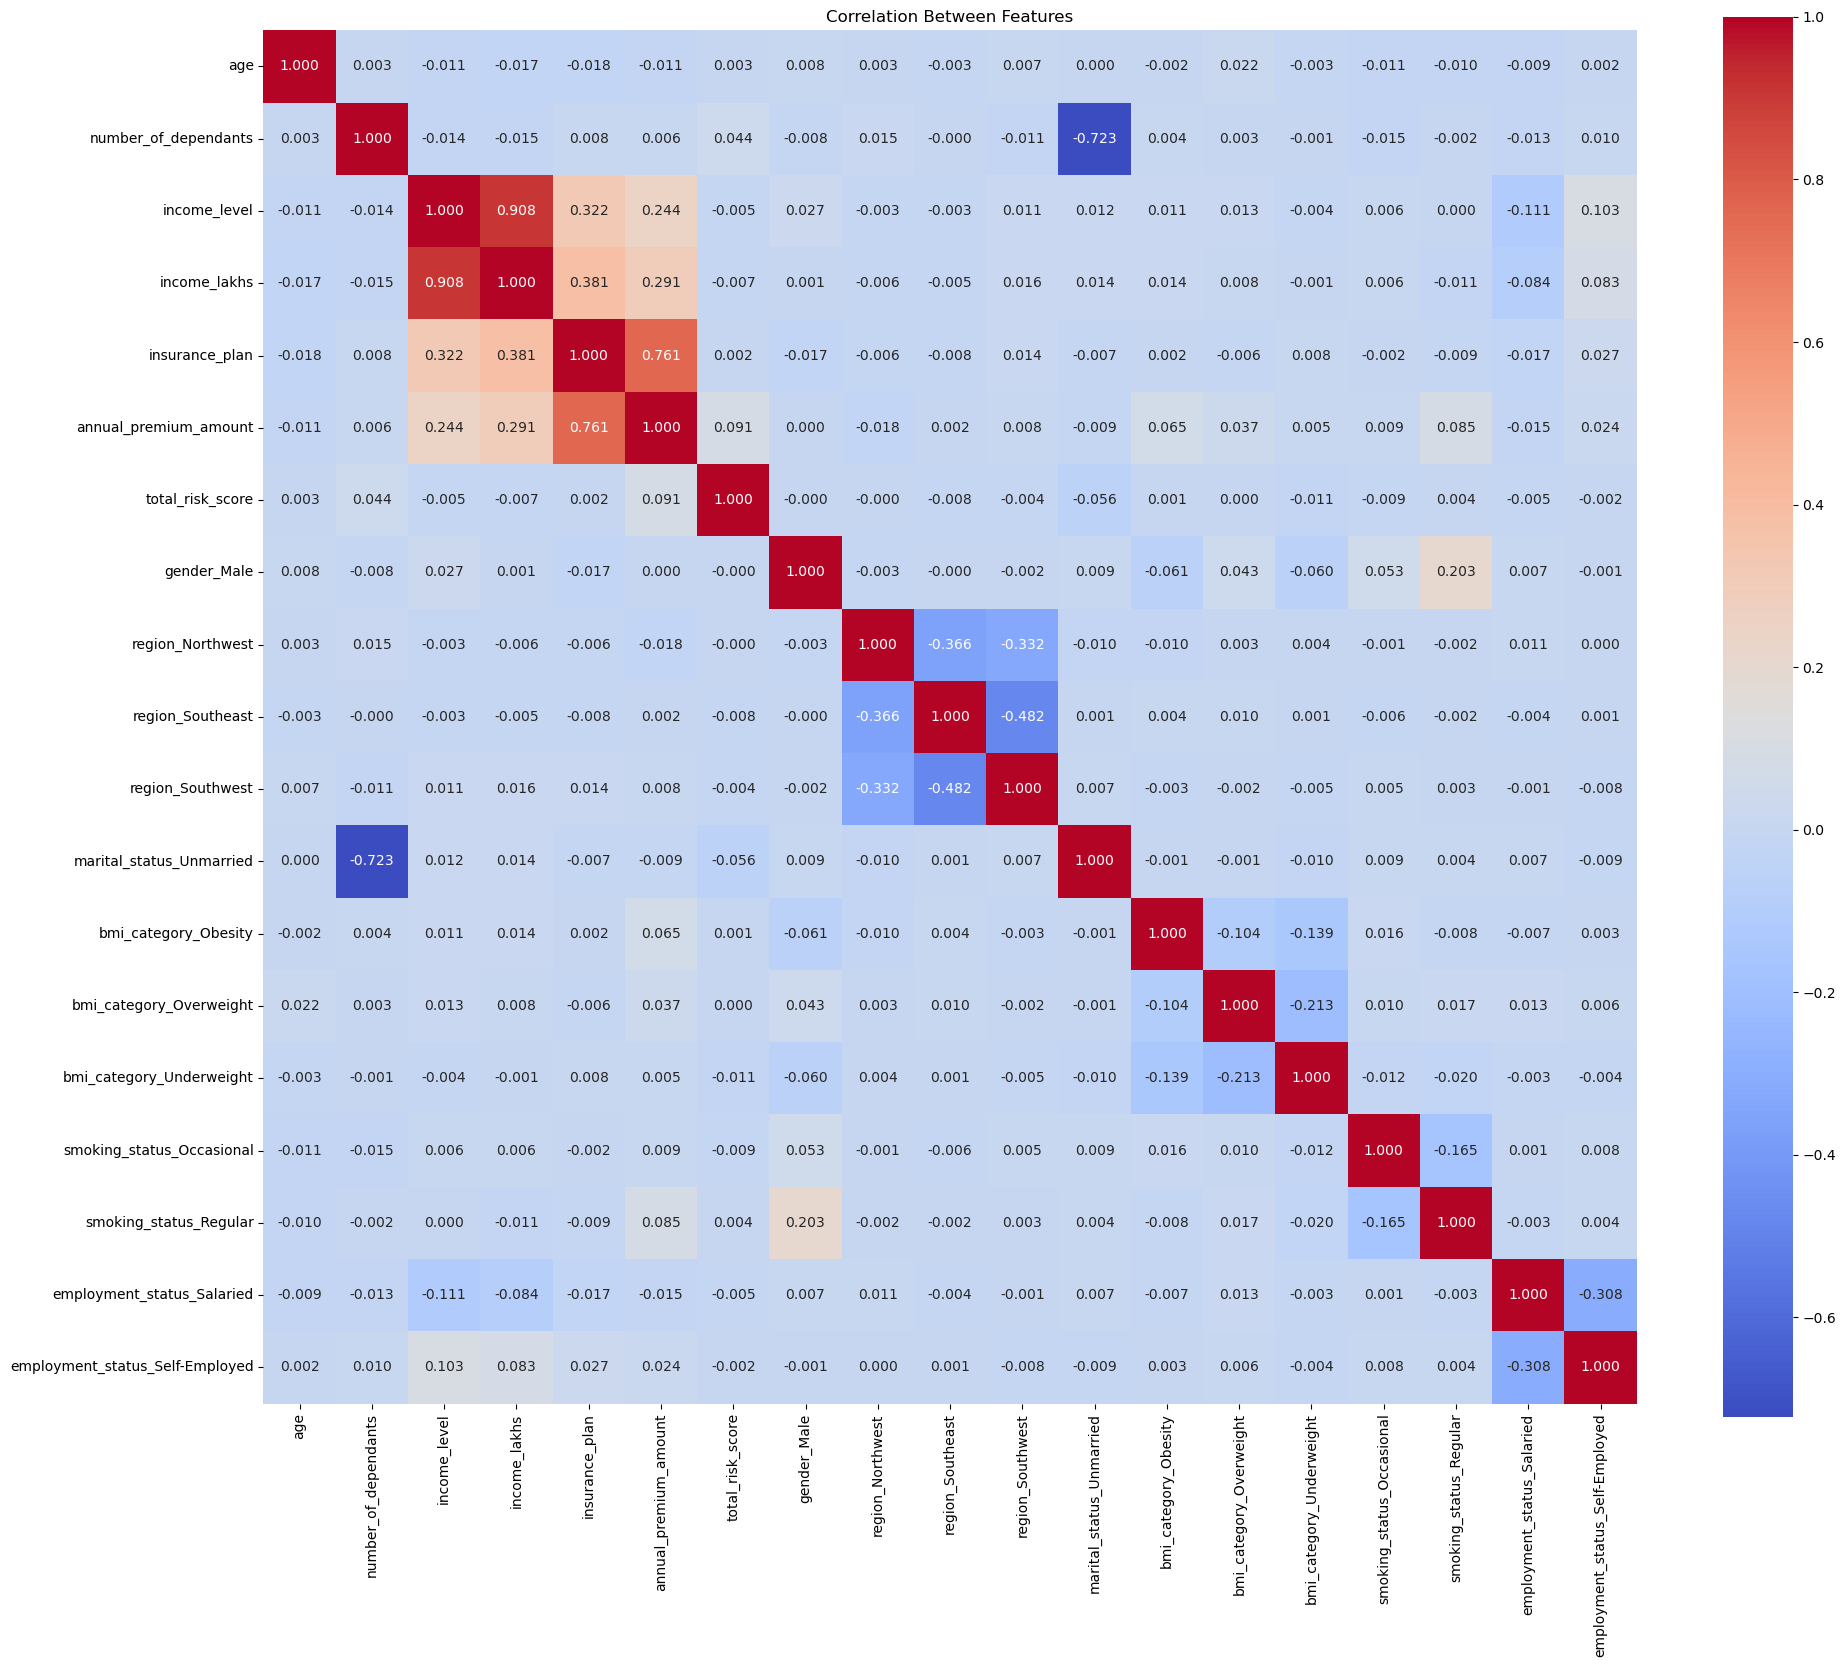

In [79]:
# Correlation Matrix displayed as a Heatmap

plt.figure(figsize=(20,20))
sns.heatmap(cr, annot=True, fmt='.3f', cmap='coolwarm', square=True, cbar_kws={"shrink": 0.75})
plt.title('Correlation Between Features')
plt.tight_layout()
plt.show()

In [80]:
# Display features that have a high correlation (|correlation| > 0.2) with 'annual_premium_amount'

cr[abs(cr['annual_premium_amount']) > 0.2]['annual_premium_amount']

income_level             0.244373
income_lakhs             0.290683
insurance_plan           0.761004
annual_premium_amount    1.000000
Name: annual_premium_amount, dtype: float64

In [81]:
# Extract the feature names (index labels) that have a high correlation (|correlation| > 0.2) with 'annual_premium_amount'

cr[abs(cr['annual_premium_amount']) > 0.2]['annual_premium_amount'].index

Index(['income_level', 'income_lakhs', 'insurance_plan',
       'annual_premium_amount'],
      dtype='object')

**Observation**

Based on the correlation heatmap, a ***strong positive correlation*** with `annual_premium_amount` is observed for the features `income_level`, `income_lakhs`, `insurance_plan` suggesting that these variables may significantly influence premium prediction.

***No strong negative correlation was observed***, indicating that no variables show a clear inverse relationship with premium amounts.

#### Variance Inflation Factor (VIF)

The Variance Inflation Factor (VIF) will be checked to detect and address multicollinearity among the features.


In [82]:
df7.columns

Index(['age', 'number_of_dependants', 'income_level', 'income_lakhs',
       'insurance_plan', 'annual_premium_amount', 'total_risk_score',
       'gender_Male', 'region_Northwest', 'region_Southeast',
       'region_Southwest', 'marital_status_Unmarried', 'bmi_category_Obesity',
       'bmi_category_Overweight', 'bmi_category_Underweight',
       'smoking_status_Occasional', 'smoking_status_Regular',
       'employment_status_Salaried', 'employment_status_Self-Employed'],
      dtype='object')

In [83]:
# Calculate VIF for each feature and store the results in a new DataFrame

# Initialize a dictionary to store feature names and their corresponding VIF scores
vif_dict = {'features':[],'vif_score':[]}

# Exclude the target variable from VIF calculation
temp_df = df7.drop('annual_premium_amount',axis=1)

# Loop through each feature to compute VIF
for i,col in enumerate(temp_df.columns):
    # Calculate the Variance Inflation Factor for the current feature
    vif = variance_inflation_factor(temp_df,i)

    # Append the feature name and its VIF score to the dictionary
    vif_dict['features'].append(col)
    vif_dict['vif_score'].append(vif)

In [84]:
# Convert the VIF dictionary into a DataFrame for better readability and analysis
vif_df = pd.DataFrame(vif_dict)

# Sort features by their VIF scores in descending order to identify highly collinear features
vif_df.sort_values(by='vif_score',ascending=False)

,features,vif_score
2,income_level,11.928707
3,income_lakhs,11.874242
10,marital_status_Unmarried,7.326373
0,age,3.142881
8,region_Southeast,2.970188
9,region_Southwest,2.730503
6,gender_Male,2.310023
7,region_Northwest,2.147701
1,number_of_dependants,1.860761
16,employment_status_Salaried,1.672615


After the Variance Inflation Factor (VIF) was calculated for all features, it was observed that both `income_level` and `income_lakhs` had VIF scores exceeding the commonly accepted threshold of 10, indicating the presence of high multicollinearity between them.

To address this issue and enhance model stability, the `income_level` feature was dropped, as it exhibited the higher VIF value of the two. This step was taken to reduce redundancy without significantly compromising the information contained in the dataset.

In [85]:
# Initialize a list to store highly collinear features to be removed later

high_vif_features  = []

In [86]:
# Identify the feature with the highest VIF score and add it to the removal list 'high_vif_features'

highest_vif_feature = vif_df['features'][vif_df['vif_score'].idxmax()]
high_vif_features.append(highest_vif_feature)
print(high_vif_features)

['income_level']


In [87]:
# Drop the most collinear feature from the temporary DataFrame

temp_df1 = temp_df.drop(['income_level'],axis=1).copy()
temp_df1

,age,number_of_dependants,income_lakhs,insurance_plan,total_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,0.000000,0.000000,0.989899,0.5,0.428571,1,0,0,0,1,0,1,0,0,1,0,1
1,0.571429,0.000000,0.020202,0.5,0.000000,0,1,0,0,1,0,0,1,0,0,0,0
2,0.428571,0.000000,0.969697,0.5,0.000000,0,0,1,0,1,0,0,0,0,1,1,0
3,1.000000,0.000000,0.141414,0.0,0.000000,1,0,1,0,1,0,0,0,0,0,0,0
4,0.285714,0.666667,0.131313,0.0,0.000000,1,0,1,0,1,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20081,0.000000,0.000000,0.909091,1.0,0.000000,0,0,1,0,1,0,0,1,0,0,0,0
20082,0.714286,0.000000,0.565657,1.0,0.428571,0,1,0,0,1,1,0,0,1,0,0,0
20083,0.857143,0.000000,0.343434,0.0,0.000000,0,1,0,0,1,0,0,1,0,0,0,1
20084,0.428571,0.000000,0.313131,0.0,0.000000,1,1,0,0,1,0,0,0,0,1,0,0


The same process will be repeated until all VIF values are within the acceptable threshold.

In [88]:
# Recalculate VIF scores for the updated feature set

vif_dict = {'features':[],'vif_score':[]}

for i,col in enumerate(temp_df1.columns):
    vif = variance_inflation_factor(temp_df1,i)
    vif_dict['features'].append(col)
    vif_dict['vif_score'].append(vif)

# Create a DataFrame from the updated VIF scores
vif_df = pd.DataFrame(vif_dict)

# Sort VIF scores in descending order to identify next candidates for removal
vif_df.sort_values(by='vif_score',ascending=False)

,features,vif_score
9,marital_status_Unmarried,7.299818
0,age,3.141534
7,region_Southeast,2.968993
8,region_Southwest,2.729813
5,gender_Male,2.299848
2,income_lakhs,2.291873
6,region_Northwest,2.146767
1,number_of_dependants,1.858110
15,employment_status_Salaried,1.666719
3,insurance_plan,1.587794


All remaining features have acceptable VIF scores.

In [89]:
# Remove the previously identified high-VIF features from the original DataFrame.
final_df = df7.drop(high_vif_features,axis=1)

# Display the final cleaned dataset
final_df

,age,number_of_dependants,income_lakhs,insurance_plan,annual_premium_amount,total_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,0.000000,0.000000,0.989899,0.5,13365,0.428571,1,0,0,0,1,0,1,0,0,1,0,1
1,0.571429,0.000000,0.020202,0.5,11050,0.000000,0,1,0,0,1,0,0,1,0,0,0,0
2,0.428571,0.000000,0.969697,0.5,11857,0.000000,0,0,1,0,1,0,0,0,0,1,1,0
3,1.000000,0.000000,0.141414,0.0,5684,0.000000,1,0,1,0,1,0,0,0,0,0,0,0
4,0.285714,0.666667,0.131313,0.0,5712,0.000000,1,0,1,0,1,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20081,0.000000,0.000000,0.909091,1.0,11603,0.000000,0,0,1,0,1,0,0,1,0,0,0,0
20082,0.714286,0.000000,0.565657,1.0,14498,0.428571,0,1,0,0,1,1,0,0,1,0,0,0
20083,0.857143,0.000000,0.343434,0.0,9111,0.000000,0,1,0,0,1,0,0,1,0,0,0,1
20084,0.428571,0.000000,0.313131,0.0,8564,0.000000,1,1,0,0,1,0,0,0,0,1,0,0


## Model Selection

The model selection process proceeded as follows:

1. Split the dataset into training and test sets.  
2. Trained different models on the training data.  
3. Used cross-validation to compare model performance.  
4. Tuned hyperparameters of the best model.  
5. Evaluated the final model’s performance on the test set. 

### Dataset Split

The dataset is divided as follows:

- Training set: 70%
- Test set: 30%

Split was done randomly with a fixed seed for reproducibility.

In [90]:
# Separate features and target variable

features = final_df.drop(['annual_premium_amount'],axis=1)
target = final_df['annual_premium_amount']

In [91]:
# Split the data into training and test sets

X_train,X_test,y_train,y_test = train_test_split(features,target,test_size=0.3,random_state=42)

In [92]:
# Display the shape of training and test sets

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (14060, 17), y_train shape: (14060,)
X_test shape: (6026, 17), y_test shape: (6026,)


### Model Training

Various models will be tried and training will be performed, including:

* Linear Regression  
* Ridge Regression  
* Lasso Regression  
* Random Forest Regressor  
* XGBoost Regressor

#### Linear Regression

In [93]:
# Initialize and train the Linear Regression model
lr=LinearRegression()
lr.fit(X_train,y_train)

# Evaluate model performance
train_score = lr.score(X_train,y_train)
test_score = lr.score(X_test,y_test)

# Print the R² scores
print(f'Train Score : {train_score} , Test Score : {test_score} ')

Train Score : 0.6038233962462742 , Test Score : 0.6006143379050811 


In [94]:
# Predict on test data
y_pred = lr.predict(X_test)

# Calculate Mean Squared Error and Root Mean Squared Error
mse = mean_squared_error(y_test,y_pred)
rmse = root_mean_squared_error(y_test,y_pred)

# Print performance metrics
print(f'MSE : {mse} , RMSE : {rmse}')

MSE : 3042911.242917956 , RMSE : 1744.3942338009363


In [95]:
# Feature Names and Its Coefficents

print('Features -> ',lr.feature_names_in_)
print('\n','**'*50)
print('Coef -> ',lr.coef_)

Features ->  ['age' 'number_of_dependants' 'income_lakhs' 'insurance_plan'
 'total_risk_score' 'gender_Male' 'region_Northwest' 'region_Southeast'
 'region_Southwest' 'marital_status_Unmarried' 'bmi_category_Obesity'
 'bmi_category_Overweight' 'bmi_category_Underweight'
 'smoking_status_Occasional' 'smoking_status_Regular'
 'employment_status_Salaried' 'employment_status_Self-Employed']

 ****************************************************************************************************
Coef ->  [ 2.36884148e+01 -2.81603858e+01  6.06515998e+01  6.97000722e+03
  1.14617372e+03  2.27709031e+00 -8.85129128e+01 -2.63407586e+00
  4.00535339e-01  3.11161583e+00  8.48014989e+02  3.85748545e+02
  1.86980641e+02  2.89716954e+02  6.32388157e+02  7.72265002e+00
  2.18415123e+01]


In [96]:
# Creating a dataframe of features and coefficients

feat_coef = {
    'features' : lr.feature_names_in_,
    'coef' : lr.coef_
}

feat_coef_df = pd.DataFrame(feat_coef)
feat_coef_df.sort_values(by=['coef'],ascending=False)

,features,coef
3,insurance_plan,6970.007217
4,total_risk_score,1146.173723
10,bmi_category_Obesity,848.014989
14,smoking_status_Regular,632.388157
11,bmi_category_Overweight,385.748545
13,smoking_status_Occasional,289.716954
12,bmi_category_Underweight,186.980641
2,income_lakhs,60.651600
0,age,23.688415
16,employment_status_Self-Employed,21.841512


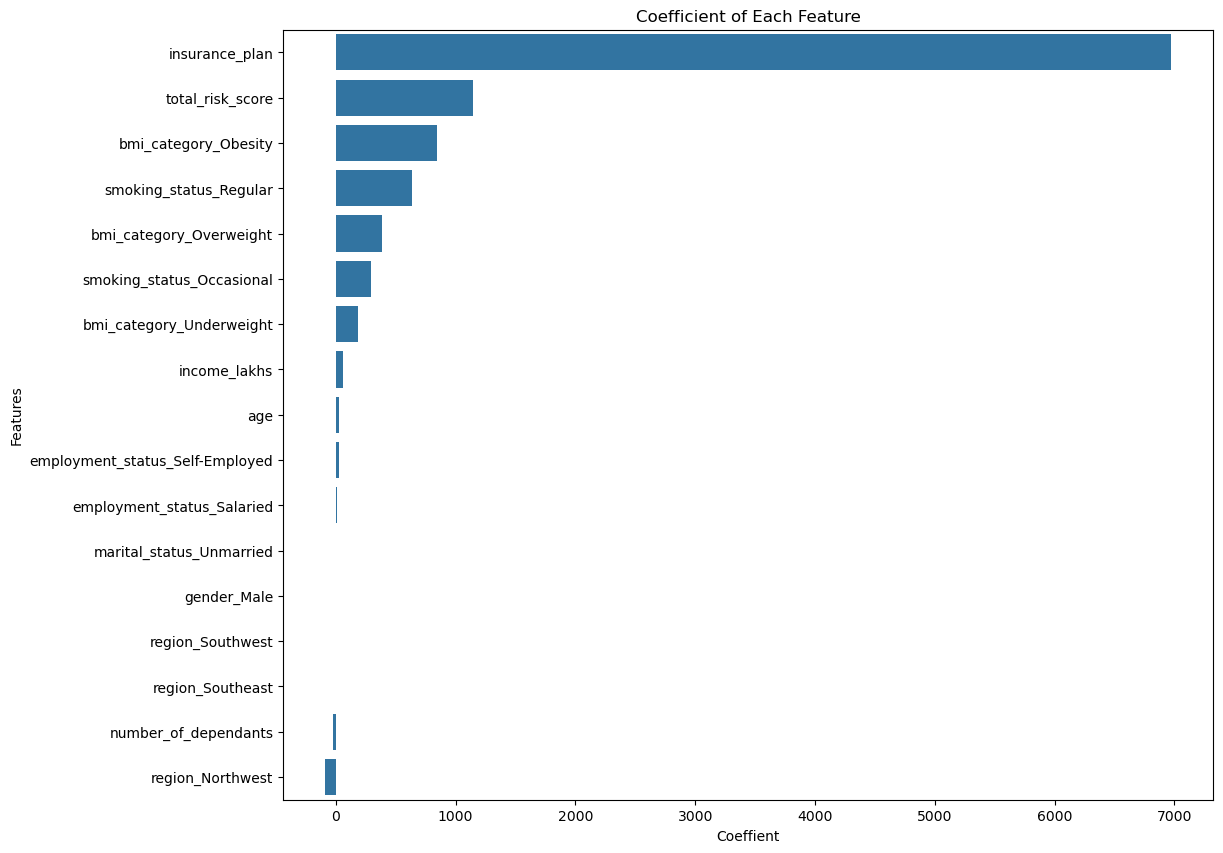

In [97]:
# Plotting the features and its coefficients

plt.figure(figsize=(12,10))
sns.barplot(data=feat_coef_df.sort_values(by=['coef'],ascending=False),x = 'coef',y = 'features' )
plt.title('Coefficient of Each Feature')
plt.xlabel('Coeffient')
plt.ylabel('Features')
plt.show()

#### Lasso Regression

In [98]:
# Initialize and train the Lasso Regression model
ls = Lasso()
ls.fit(X_train,y_train)

# Evaluate model performance
train_score = ls.score(X_train,y_train)
test_score = ls.score(X_test,y_test)

# Print the R² scores
print(f'Train Score : {train_score} , Test Score : {test_score} ')

Train Score : 0.6038029812682746 , Test Score : 0.6008247568128317 


In [99]:
# Predict on test data
y_pred = ls.predict(X_test)

# Calculate Mean Squared Error and Root Mean Squared Error
mse = mean_squared_error(y_test,y_pred)
rmse = root_mean_squared_error(y_test,y_pred)

# Print performance metrics
print(f'MSE : {mse} , RMSE : {rmse}')

MSE : 3041308.0655360785 , RMSE : 1743.9346505921828


#### Ridge Regression

In [100]:
# Initialize and train the Ridge Regression model
rg = Ridge()
rg.fit(X_train,y_train)

# Evaluate model performance
train_score = rg.score(X_train,y_train)
test_score = rg.score(X_test,y_test)

# Print the R² scores
print(f'Train Score : {train_score} , Test Score : {test_score} ')

Train Score : 0.6038229410962822 , Test Score : 0.6006176945835398 


In [101]:
# Predict on test data
y_pred = rg.predict(X_test)

# Calculate Mean Squared Error and Root Mean Squared Error
mse = mean_squared_error(y_test,y_pred)
rmse = root_mean_squared_error(y_test,y_pred)

# Print performance metrics
print(f'MSE : {mse} , RMSE : {rmse}')

MSE : 3042885.6684529963 , RMSE : 1744.3869033138824


**Observation**

Neither Lasso nor Ridge regression showed significant improvement over Linear Regression.

#### Random Forest Regressor

In [102]:
# Initialize and train the Random Forest Regression model
rfr = RandomForestRegressor()
rfr.fit(X_train,y_train)

# Evaluate model performance
train_score = rfr.score(X_train,y_train)
test_score = rfr.score(X_test,y_test)

# Print the R² scores
print(f'Train Score : {train_score} , Test Score : {test_score} ')

Train Score : 0.9241734191002452 , Test Score : 0.5323172500344429 


In [103]:
# Predict on test data
y_pred = rfr.predict(X_test)

# Calculate Mean Squared Error and Root Mean Squared Error
mse = mean_squared_error(y_test,y_pred)
rmse = root_mean_squared_error(y_test,y_pred)

# Print performance metrics
print(f'MSE : {mse} , RMSE : {rmse}')

MSE : 3563265.3674251325 , RMSE : 1887.6613487130398


#### XGboost Regressor

In [104]:
# Initialize and train the XGboost model
xgb = XGBRegressor()
xgb.fit(X_train,y_train)

# Evaluate model performance
train_score = xgb.score(X_train,y_train)
test_score = xgb.score(X_test,y_test)

# Print the R² scores
print(f'Train Score : {train_score} , Test Score : {test_score} ')

Train Score : 0.7260478138923645 , Test Score : 0.5608752965927124 


In [105]:
# Predict on test data
y_pred = xgb.predict(X_test)

# Calculate Mean Squared Error and Root Mean Squared Error
mse = mean_squared_error(y_test,y_pred)
rmse = root_mean_squared_error(y_test,y_pred)

# Print performance metrics
print(f'MSE : {mse} , RMSE : {rmse}')

MSE : 3345682.25 , RMSE : 1829.12060546875


**Model Performance Comparison: XGBoost vs. Random Forest**

Both XGBoost and Random Forest models are observed to performed better on the dataset. However, the following points are noted:

- A lower training score and a higher test score are yielded by the XGBoost model compared to Random Forest.
- This suggests that the XGBoost model generalizes better and is less prone to overfitting.
- To validate this observation, cross-validation will be used to evaluate both models more robustly using `cross_validate`.

### Cross Validation - RF vs XGboost

Cross-validation will be performed on both Random Forest and XGBoost models, with the run time also being recorded.  
The `cross_validate` function is used instead of `cross_val_score` to obtain both training and testing scores.

Stratified K-Fold will not be performed since this is a regression task; therefore, K-Fold cross-validation is considered sufficient.

In [106]:
# Set up 5-fold cross-validation

kf = KFold(n_splits = 5,shuffle=True,random_state=42)

In [107]:
# Perform cross-validation for Random Forest Regressor

start_time = time()
cv_rfr = cross_validate(rfr,features,target,cv=kf,return_train_score=True,scoring='r2')
end_time = time()
total_time_rfr = end_time - start_time
print(f'Total Time Taken : {round(total_time_rfr,2)} seconds')

Total Time Taken : 51.62 seconds


In [108]:
# Display training scores
print("Training scores (R²):", cv_rfr['train_score'])

# Display test scores
print("Validation scores (R²):", cv_rfr['test_score'])

Training scores (R²): [0.92186826 0.92233103 0.9212611  0.92235209 0.92055617]
Validation scores (R²): [0.52746739 0.53940239 0.54238878 0.52804131 0.54435787]


In [109]:
# Perform cross-validation for XGboost Regressor

start_time = time()
cv_xgb = cross_validate(xgb,features,target,cv=kf,return_train_score=True,scoring='r2')
end_time = time()
total_time_xgb = end_time - start_time
print(f'Total Time Taken : {round(total_time_xgb,2)} seconds')

Total Time Taken : 1.21 seconds


In [110]:
# Display training scores
print("Training scores (R²):", cv_xgb['train_score'])

# Display test scores
print("Validation scores (R²):", cv_xgb['test_score'])

Training scores (R²): [0.71529818 0.71619761 0.71522385 0.71640158 0.71656138]
Validation scores (R²): [0.55446351 0.57049286 0.57640862 0.56741273 0.56929308]


In [111]:
cv_df = pd.DataFrame(
    {
        'model' : ['Random Forest','XGboost'],
        'execution_time (seconds)' : [total_time_rfr,total_time_xgb],
        'average_train_score' : [np.mean(cv_rfr['train_score']),np.mean(cv_xgb['train_score'])],
        'average_test_score' : [np.mean(cv_rfr['test_score']),np.mean(cv_xgb['test_score'])]
    }
)

cv_df

,model,execution_time (seconds),average_train_score,average_test_score
0,Random Forest,51.616210,0.921674,0.536332
1,XGboost,1.207661,0.715937,0.567614


**Cross-Validation Summary: XGBoost vs. Random Forest**

The cross-validation results confirm that XGBoost is consistently observed to generalize better than the Random Forest model:

- *Lower training scores* and *higher test scores* were achieved by XGBoost, indicating *better generalization* and *reduced overfitting*.
- In terms of performance, XGBoost was approximately ***37 times faster*** than Random Forest during cross-validation.

Given its superior predictive performance and computational efficiency, **XGBoost will be selected as the final model**.


### Hyperparameter Tuning

The model will be fine-tuned using `RandomizedSearchCV`, as it is computationally less expensive than `GridSearchCV`.

Hyperparameter combinations are randomly sampled, making this approach generally faster for large search spaces.

#### RandomizedSearchCV

In [112]:
xgb = XGBRegressor(booster= 'gbtree')

In [113]:
param_grid = {
    'n_estimators' : [100,200,300],
    'learning_rate' : [0.1,0.15,0.2],
    'max_depth' : [7,8,9],
    'gamma' : [1,2,3]
    
}

A total of 81 hyperparameter combinations are available. A smaller subset of combinations will be selected to reduce computational cost.

In [114]:
# Adjust based on resources

iter_to_perform = 10

In [115]:
# Initialize RandomizedSearchCV

rscv = RandomizedSearchCV(xgb,param_grid,cv=kf,n_iter=iter_to_perform,random_state=42)

In [116]:
# Executing RandomizedSearchCV and Timing the search

start_time = time()
rscv.fit(features,target)
end_time = time()
total_time_xgb_hyp = end_time - start_time
print(f'Total Time Taken : {round(total_time_xgb_hyp,2)} seconds')

Total Time Taken : 29.07 seconds


#### Best Model

In [117]:
# Displaying the results of RandomizedSearchCV execution

pd.DataFrame(rscv.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_max_depth,param_learning_rate,param_gamma,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.347415,0.024011,0.017277,0.002615,100,8,0.10,2,"{'n_estimators': 100, 'max_depth': 8, 'learnin...",0.568815,0.578301,0.579184,0.570187,0.576064,0.574510,0.004237,2
1,0.262445,0.019097,0.015116,0.002172,100,7,0.10,1,"{'n_estimators': 100, 'max_depth': 7, 'learnin...",0.576053,0.587760,0.587450,0.584086,0.584240,0.583918,0.004224,1
2,0.682002,0.026723,0.021017,0.000692,200,8,0.20,1,"{'n_estimators': 200, 'max_depth': 8, 'learnin...",0.505464,0.515974,0.523235,0.508586,0.525143,0.515681,0.007764,9
3,0.644116,0.024097,0.022050,0.002027,200,8,0.10,2,"{'n_estimators': 200, 'max_depth': 8, 'learnin...",0.552036,0.557137,0.559327,0.549646,0.553752,0.554380,0.003475,7
4,0.368118,0.100120,0.014947,0.001134,100,7,0.20,1,"{'n_estimators': 100, 'max_depth': 7, 'learnin...",0.555129,0.563157,0.569224,0.563309,0.563205,0.562805,0.004487,5
5,0.552609,0.085025,0.020562,0.002088,200,7,0.10,2,"{'n_estimators': 200, 'max_depth': 7, 'learnin...",0.562248,0.571701,0.571273,0.571375,0.571645,0.569648,0.003704,3
6,0.574641,0.029900,0.022045,0.002355,200,7,0.15,1,"{'n_estimators': 200, 'max_depth': 7, 'learnin...",0.546492,0.555208,0.555033,0.554349,0.561863,0.554589,0.004881,6
7,0.942826,0.091793,0.023310,0.001362,200,9,0.15,3,"{'n_estimators': 200, 'max_depth': 9, 'learnin...",0.508345,0.515835,0.513487,0.497188,0.518425,0.510656,0.007509,10
8,0.701700,0.060228,0.025085,0.006813,200,8,0.10,1,"{'n_estimators': 200, 'max_depth': 8, 'learnin...",0.552036,0.557137,0.559327,0.549646,0.553752,0.554380,0.003475,7
9,0.428891,0.066735,0.015211,0.000533,100,8,0.15,1,"{'n_estimators': 100, 'max_depth': 8, 'learnin...",0.556069,0.567151,0.566113,0.561880,0.566143,0.563471,0.004123,4


In [118]:
# Best score we get from the Tuning

rscv.best_score_

np.float64(0.5839179277420044)

In [119]:
# Parameters that gave the best score

rscv.best_params_

{'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.1, 'gamma': 1}

In [120]:
# Model that resulted the best score

best_model = rscv.best_estimator_
best_model

XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=1, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

### Performance of the 'Best Model'

The best model’s performance was evaluated on the test set to assess its real-world effectiveness.

#### Scores

In [121]:
# Evaluate Best model's performance
train_score = best_model.score(X_train,y_train)
test_score = best_model.score(X_test,y_test)

# Print the R² scores
print(f'Train Score : {train_score} , Test Score : {test_score} ')

Train Score : 0.6753562092781067 , Test Score : 0.6709475517272949 


The best model's training and test scores are very low.  
However, this outcome is understandable because the age group 18-25 is responsible for more extreme errors in the original dataset.

In [122]:
# Predict on test data
y_pred = best_model.predict(X_test)

# Calculate Mean Squared Error and Root Mean Squared Error
mse = mean_squared_error(y_test,y_pred)
rmse = root_mean_squared_error(y_test,y_pred)

# Print performance metrics of the best model
print(f'MSE : {mse} , RMSE : {rmse}')

MSE : 2507044.25 , RMSE : 1583.3648681640625


#### Features and their Importance

The contribution of each feature to the model's predictions was analyzed.

In [123]:
# Retrieve feature names used during model training (available after fitting)

best_model.feature_names_in_

array(['age', 'number_of_dependants', 'income_lakhs', 'insurance_plan',
       'total_risk_score', 'gender_Male', 'region_Northwest',
       'region_Southeast', 'region_Southwest', 'marital_status_Unmarried',
       'bmi_category_Obesity', 'bmi_category_Overweight',
       'bmi_category_Underweight', 'smoking_status_Occasional',
       'smoking_status_Regular', 'employment_status_Salaried',
       'employment_status_Self-Employed'], dtype='<U31')

In [124]:
# Feature importance scores from the fitted model

best_model.feature_importances_

array([0.00277251, 0.00296853, 0.00330429, 0.9230467 , 0.00830317,
       0.00309849, 0.00316672, 0.00375645, 0.00309433, 0.00317882,
       0.00857145, 0.0058698 , 0.00356086, 0.00359178, 0.01480008,
       0.00351751, 0.00339839], dtype=float32)

In [125]:
# Create a DataFrame of features and their corresponding importance scores
feat_coef_df = pd.DataFrame(
    {
        'features' : best_model.feature_names_in_,
        'importance' : best_model.feature_importances_
    }
)

# Sort the features by importance in descending order
feat_coef_df = feat_coef_df.sort_values(by=['importance'],ascending=False)
feat_coef_df

,features,importance
3,insurance_plan,0.923047
14,smoking_status_Regular,0.014800
10,bmi_category_Obesity,0.008571
4,total_risk_score,0.008303
11,bmi_category_Overweight,0.005870
7,region_Southeast,0.003756
13,smoking_status_Occasional,0.003592
12,bmi_category_Underweight,0.003561
15,employment_status_Salaried,0.003518
16,employment_status_Self-Employed,0.003398


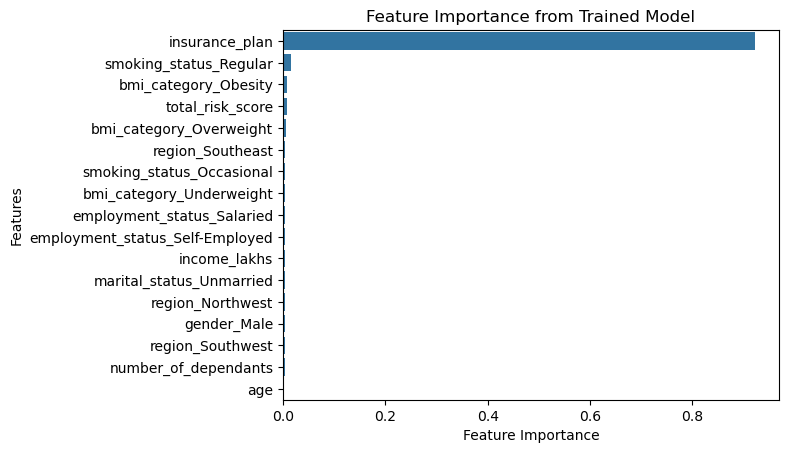

In [126]:
# Plot feature importances using a horizontal bar chart
sns.barplot(data = feat_coef_df, x='importance',y='features')
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importance from Trained Model")
plt.show()

## Error Anlysis

The prediction errors (residuals) will be analyzed to evaluate the model’s performance.

**Objective:**  
Ensure that 95% of incorrect predictions deviate by ≤10% from the actual values.

**Approach:**  
- Residuals will be calculated as: residual = actual − predicted  
- Percentage error relative to actual values will be computed.  
- The proportion of errors falling within the 10% threshold will be checked.  
- Any consistent error patterns across customer segments will be identified.

In [127]:
# Predict on test data

y_pred = best_model.predict(X_test)

In [128]:
# Check the shape of predictions and actual test labels to ensure alignment

print("Predicted labels shape:", y_pred.shape)
print("Actual labels shape:", y_test.shape)

Predicted labels shape: (6026,)
Actual labels shape: (6026,)


### Residuals 

The difference between the predicted values and the actual values will be determined.

In [129]:
# Calculate residuals (difference between predicted and actual values)
residuals = y_pred - y_test

# Display the residuals
residuals

10480     919.114746
7981    -1370.658203
3111     1597.967773
10596    -932.746094
4202     2916.733398
            ...     
18950    2156.387695
266      1266.761719
10027   -1841.294922
15496     735.643555
10881   -1151.492676
Name: annual_premium_amount, Length: 6026, dtype: float64

In [130]:
# Calculate the residual percentage
# What it shows? - How much the predicted value is deviated from the actual value
# 2.68 -> Predicted Value is 2.68% higher than the actual value

residuals_pct = ((y_pred - y_test) / y_test)*100
residuals_pct

10480    16.858304
7981    -14.191947
3111     26.495901
10596    -7.530648
4202     68.709856
           ...    
18950    50.230321
266      10.654906
10027   -15.504336
15496     5.476391
10881   -13.562929
Name: annual_premium_amount, Length: 6026, dtype: float64

Everything will be put into a dataframe for better understanding.

In [131]:
# Create a dictionary to store actual, predicted, residuals, and residual percentages
residual_dict = {
    'actual' : y_test,
    'predicted' : y_pred,
    'residual' : residuals,
    'residual_pct' : residuals_pct
}

# Convert the dictionary into a DataFrame for easier analysis
residual_df = pd.DataFrame(residual_dict)

# Display the DataFrame
residual_df

,actual,predicted,residual,residual_pct
10480,5452,6371.114746,919.114746,16.858304
7981,9658,8287.341797,-1370.658203,-14.191947
3111,6031,7628.967773,1597.967773,26.495901
10596,12386,11453.253906,-932.746094,-7.530648
4202,4245,7161.733398,2916.733398,68.709856
...,...,...,...,...
18950,4293,6449.387695,2156.387695,50.230321
266,11889,13155.761719,1266.761719,10.654906
10027,11876,10034.705078,-1841.294922,-15.504336
15496,13433,14168.643555,735.643555,5.476391


In [132]:
# Sort the residual_df by residual_pct in descending order to see the largest errors first

residual_df.sort_values(by=['residual_pct'],ascending=False)

,actual,predicted,residual,residual_pct
640,3522,6915.184570,3393.184570,96.342549
8310,3527,6623.697754,3096.697754,87.799766
4367,3856,7174.063965,3318.063965,86.049377
16611,3609,6712.020996,3103.020996,85.980077
10156,3501,6486.543945,2985.543945,85.276891
...,...,...,...,...
7786,9401,6301.088379,-3099.911621,-32.974275
7703,9337,6238.271484,-3098.728516,-33.187625
9406,9630,6424.952637,-3205.047363,-33.281904
5512,9258,6158.632324,-3099.367676,-33.477724


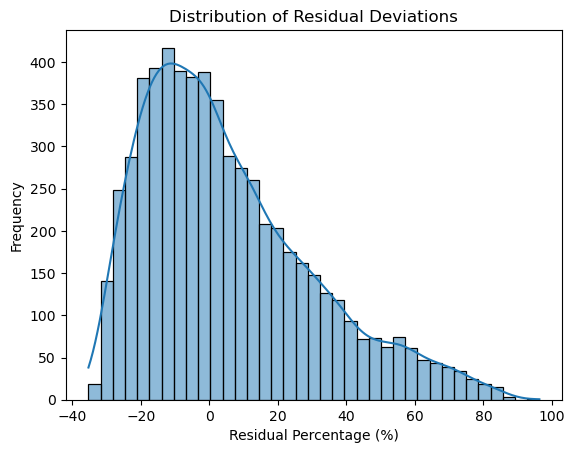

In [133]:
# Plot the distribution of residual percentages with a Kernel Density Estimate (KDE) overlay
sns.histplot(data = residual_df, x = 'residual_pct',kde=True )
plt.title('Distribution of Residual Deviations')
plt.xlabel('Residual Percentage (%)')
plt.ylabel('Frequency')
plt.show()

As noted above, certain predicted values are higher than the actual values by 40%, 50%, 60%, 70%, 80%, or even 100%, which is considered undesirable.  
Such instances will be subjected to further examination.

### Analysing Extreme Residuals

As stated in the Statement of Work (SOW):

- The goal is to ensure that 95% of incorrect predictions deviate by no more than 10% from the actual values.

This implies that even when predictions are incorrect, **95%** of them should exhibit **less than 10% deviation** - either above or below the actual values.

In other words, only **5%** of incorrect predictions are permitted to deviate by **more than 10%** from the actual values.

Based on this requirement, the deviation threshold has been set at **10%**.

In [134]:
# Acceptable percentage deviation allowed between actual and expected values

deviation_pct = 10

In [135]:
# Filter rows where the absolute residual percentage exceeds the deviation_pct (10%)
extreme_residual = residual_df[abs(residual_df['residual_pct']) > deviation_pct]

# Display a random sample of 2 such extreme residuals for inspection
extreme_residual.sample(2)

,actual,predicted,residual,residual_pct
7330,4970,6321.464844,1351.464844,27.192452
19557,12729,11062.708984,-1666.291016,-13.090510


In [136]:
# Get the number of rows and columns in the filtered DataFrame (extreme residuals)
extreme_residual.shape

(4076, 4)

In [137]:
# Get the number of rows and columns in the original residual DataFrame
residual_df.shape

(6026, 4)

In [138]:
# Calculate the percentage of residuals that exceed the deviation_pct
extreme_residual_percentage = (extreme_residual.shape[0] / residual_df.shape[0])*100

# Display the calculated percentage
extreme_residual_percentage

67.64022568868238

It has been observed that approximately **68%** of the predicted values deviate by **more than 10%** from the actual values - **1260% more** than the allowed **5%** threshold.

Where this issue originates must be determined.  
A deeper investigation is required to understand how such large residuals are produced.


In [139]:
# Retrieve the indexes of rows with residuals exceeding the defined threshold

extreme_residual.index

Index([10480,  7981,  3111,  4202, 16409,  6529,  1710, 10351, 18154, 14370,
       ...
        6211, 17321, 12369,  1022,  8227, 18532, 18950,   266, 10027, 10881],
      dtype='int64', length=4076)

In [140]:
len(extreme_residual.index)

4076

In [141]:
# Extract the original rows from X_test where the model had large prediction errors
extreme_residual_df = X_test.loc[extreme_residual.index]

# Display the extracted rows with extreme residuals
extreme_residual_df

,age,number_of_dependants,income_lakhs,insurance_plan,total_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
10480,0.428571,1.000000,0.080808,0.0,0.428571,1,0,0,0,0,0,0,0,0,0,0,0
7981,0.714286,0.000000,0.030303,0.0,1.000000,1,0,0,1,1,0,0,0,0,0,0,0
3111,0.142857,0.000000,0.363636,0.0,1.000000,1,0,0,1,1,0,0,0,0,1,1,0
4202,0.000000,0.000000,0.222222,0.0,0.000000,0,0,1,0,1,0,0,1,0,1,0,0
16409,0.285714,0.000000,0.222222,1.0,0.000000,0,0,0,1,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18532,0.285714,0.333333,0.040404,0.0,0.000000,1,0,1,0,1,1,0,0,0,0,0,0
18950,0.428571,0.333333,0.181818,0.0,0.000000,0,0,0,1,1,0,0,0,0,0,0,0
266,0.857143,0.333333,0.000000,1.0,0.000000,1,0,1,0,1,0,0,0,0,0,0,0
10027,0.857143,0.000000,0.060606,0.5,0.000000,1,0,1,0,1,0,0,0,0,0,0,0


To gain insights about the potential features that causes the large deviations, the distribution of each feature in `X_test` and `extreme_residual_df` will be plotted.

By comparing the distributions across both datasets, it can be observed how each feature behaves and whether any specific feature contributes significantly to the high residuals.

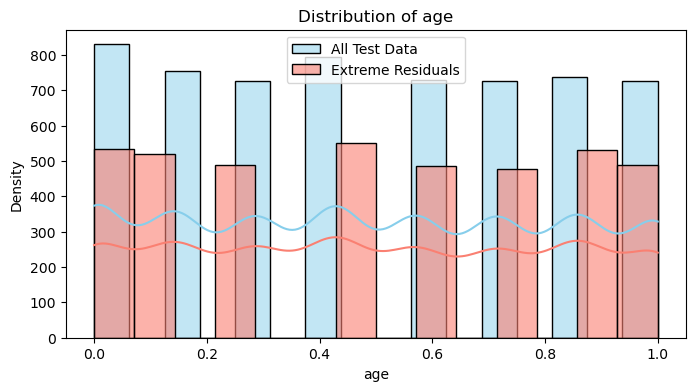

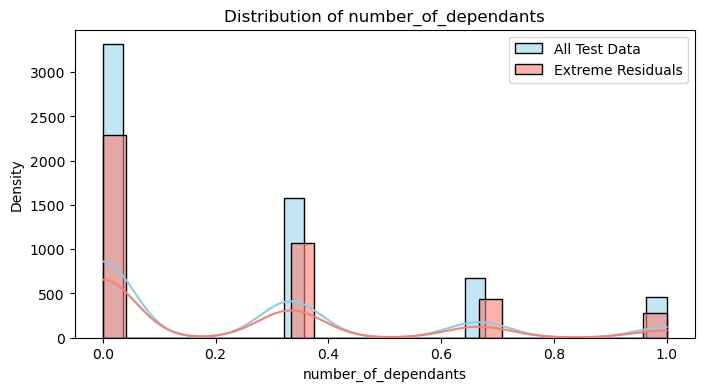

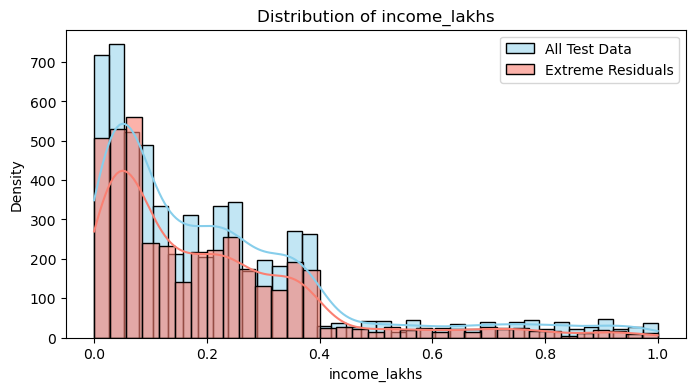

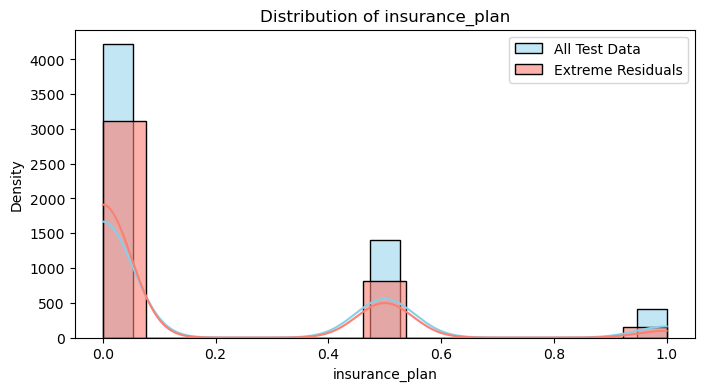

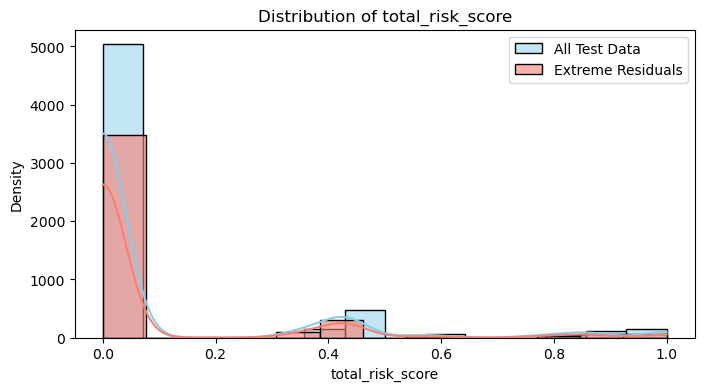

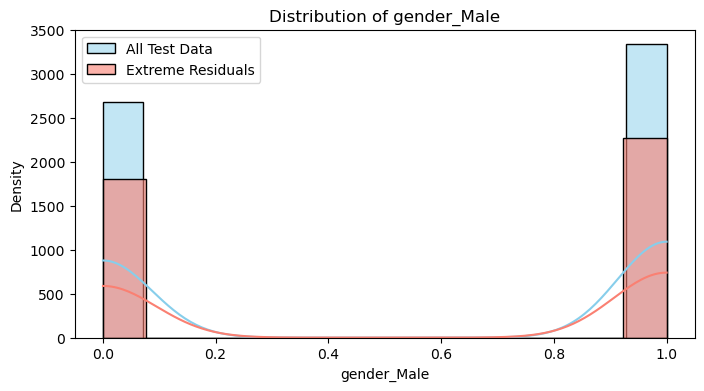

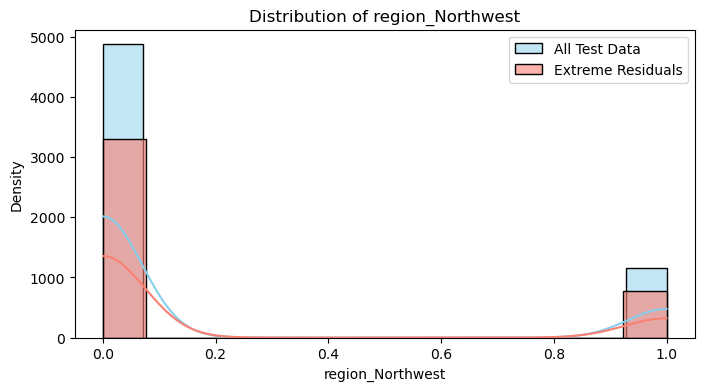

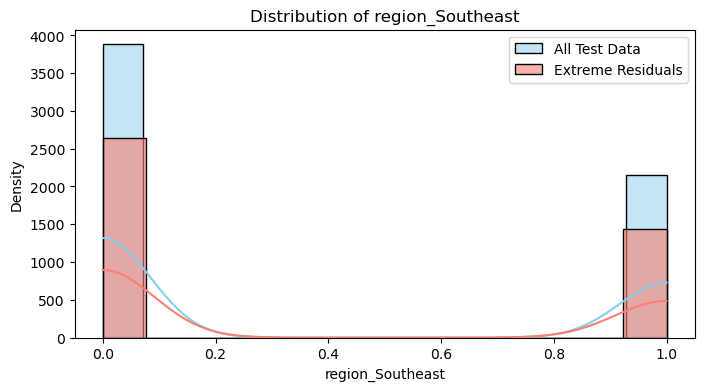

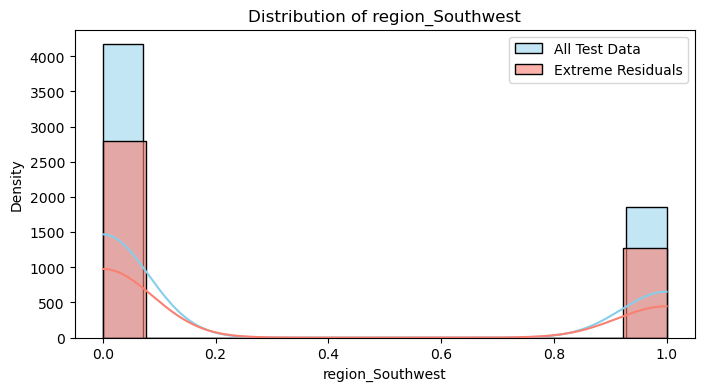

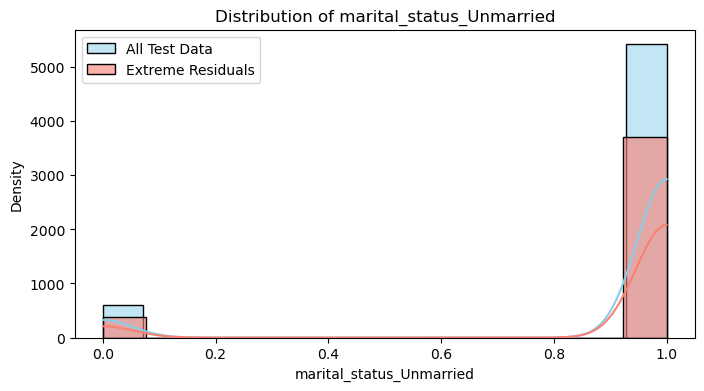

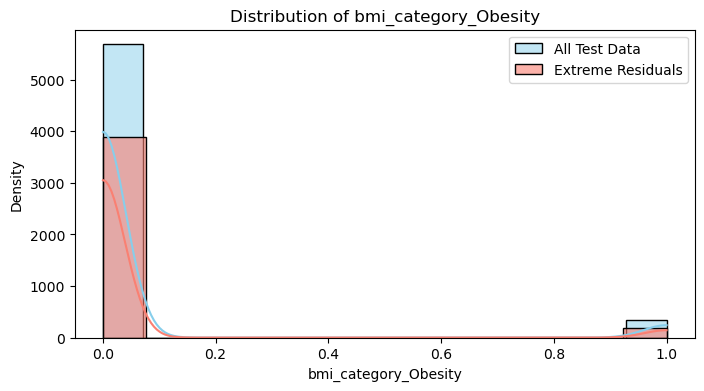

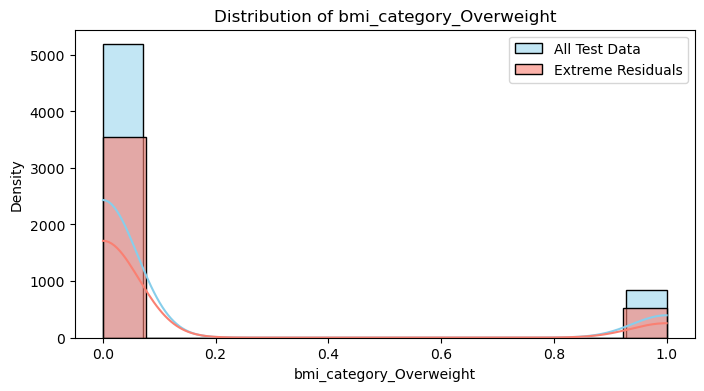

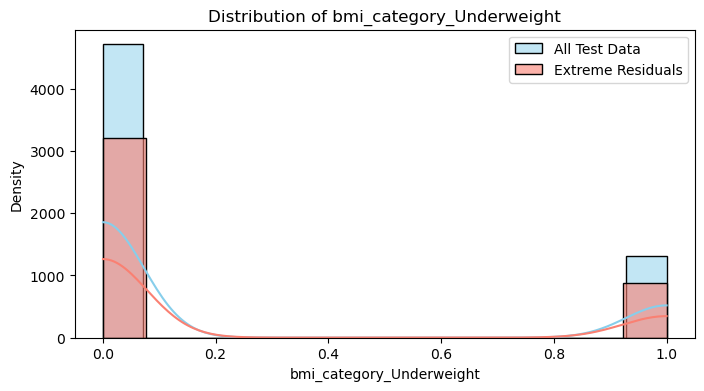

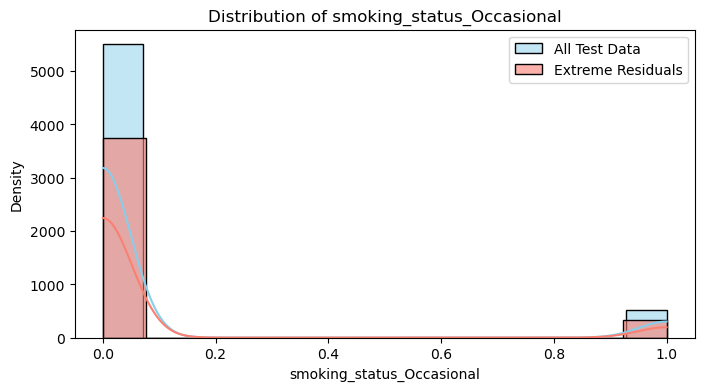

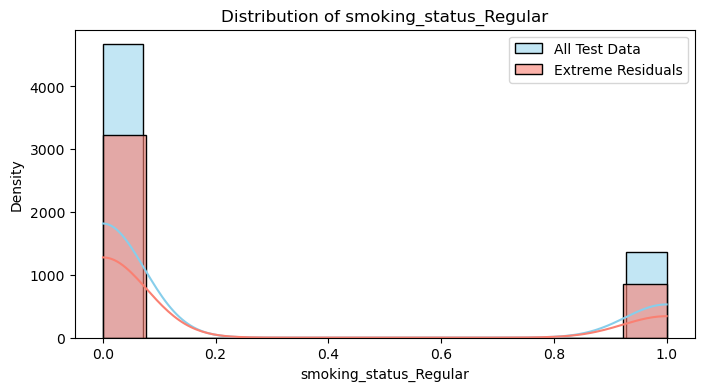

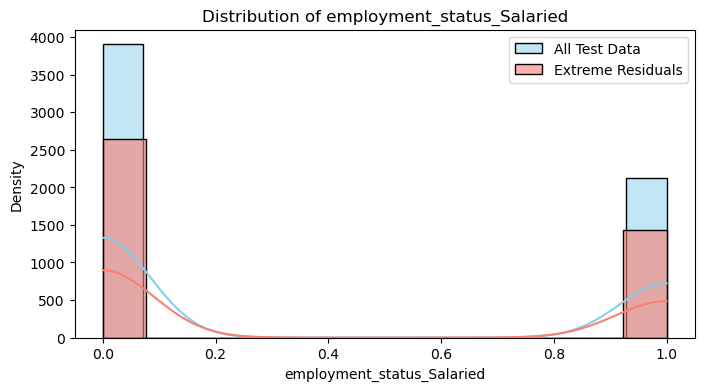

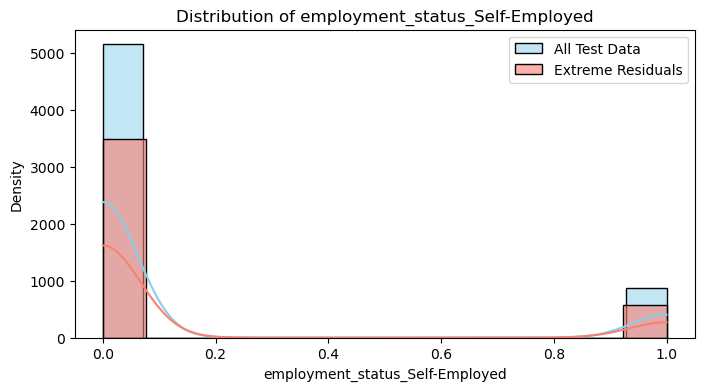

In [142]:
# Plot feature distributions to compare the X_test set vs rows with extreme residuals
for feature in X_test.columns:
    plt.figure(figsize=(8, 4))
    
    # X_test data distribution
    sns.histplot(data=X_test, x=feature, kde=True, color='skyblue', label='All Test Data', alpha=0.5)
    
    # Extreme residuals distribution
    sns.histplot(data=extreme_residual_df, x=feature, kde=True, color='salmon', label='Extreme Residuals', alpha=0.6)
    
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Density')
    plt.legend()
    plt.show()

### Features Driving Extreme Residuals

- The distribution of all features aligns closely with the original data distribution.  
- **No clear conclusion can be drawn** that errors are clustered around one or two specific features.

### Final Verdict

Given the consistent feature distributions the following actions are recommended:

1. Enhance feature selection to improve model performance.  
2. Collect more features, especially for the 18-25 age group, to reduce extreme errors.
